In [1]:
import boto3
from datetime import datetime, timedelta
from botocore import UNSIGNED
from botocore.config import Config
import xarray as xr
import cfgrib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

In [2]:
sfc_or_prs = 'sfc' # sfc or prs
typeOfLevel = 'surface' if sfc_or_prs == 'sfc' else 'isobaricInhPa'
stepType = 'instant' # instant, max, or accum, but we only want instant
save_path = "C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f01_sfc.grib2"
ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})


Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f01_sfc.grib2.5b7b6.idx' incompatible with GRIB file
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [3]:
def get_temp_grid_centered(ds, half_size):   
    lats = ds['latitude'].values  # Shape: (1059, 1799)
    lons = ds['longitude'].values  # Shape: (1059, 1799)
    temp = ds['t'].values         # Shape: (1059, 1799)

    # KBMG coordinates
    target_lat = 39.14
    target_lon = -86.62

    # Check longitude convention and adjust if necessary
    print(f"Longitude range: {lons.min()} to {lons.max()}")
    if lons.min() >= 0 and lons.max() > 180:
        target_lon = 360 + target_lon if target_lon < 0 else target_lon
        print(f"Adjusted target_lon to {target_lon}")  # Should be 273.38

    # Find the closest grid point to KBMG
    lat_diff = np.abs(lats - target_lat)
    lon_diff = np.abs(lons - target_lon)
    comb_diff = lat_diff + lon_diff
    center_y, center_x = np.unravel_index(np.argmin(comb_diff), lats.shape)

    print(f"Center indices: y={center_y}, x={center_x}")
    print(f"Center coords: lat={lats[center_y, center_x]}, lon={lons[center_y, center_x]}")


    grid_size = 2 * half_size + 1  

    temp_grid = np.full((grid_size, grid_size), np.nan, dtype=temp.dtype)
    lat_grid = np.full((grid_size, grid_size), np.nan, dtype=lats.dtype)
    lon_grid = np.full((grid_size, grid_size), np.nan, dtype=lons.dtype)

    for i in range(grid_size):
        for j in range(grid_size):
            dataset_y = center_y - half_size + i
            dataset_x = center_x - half_size + j
            if 0 <= dataset_y < lats.shape[0] and 0 <= dataset_x < lons.shape[1]:
                temp_grid[i, j] = temp[dataset_y, dataset_x] - 273.15
                lat_grid[i, j] = lats[dataset_y, dataset_x]
                lon_grid[i, j] = lons[dataset_y, dataset_x]
    return temp_grid, lat_grid, lon_grid

# Print the result
temp_grid, lat_grid, lon_grid = get_temp_grid_centered(ds, 3)
print("Temperature Grid:")
print(temp_grid)
print("KBMG temp")
print(temp_grid[3, 3])


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
Temperature Grid:
[[-0.8921509 -0.8296509 -0.7671509 -0.7671509 -0.6421509 -0.6421509
  -0.5796509]
 [-0.8296509 -0.8296509 -0.8296509 -0.7671509 -0.6421509 -0.5796509
  -0.7046509]
 [-0.7671509 -0.8296509 -0.8921509 -0.8921509 -0.7046509 -0.6421509
  -0.6421509]
 [-0.7671509 -0.7046509 -0.7671509 -0.6421509 -0.8921509 -0.7046509
  -0.6421509]
 [-0.7671509 -0.8296509 -0.8296509 -0.7671509 -0.7671509 -0.6421509
  -0.7046509]
 [-0.8296509 -0.8921509 -1.2046509 -0.6421509 -0.8921509 -0.7046509
  -0.7046509]
 [-1.0796509 -1.0796509 -1.2046509 -0.9546509 -0.9546509 -0.7671509
  -0.7671509]]
KBMG temp
-0.6421509


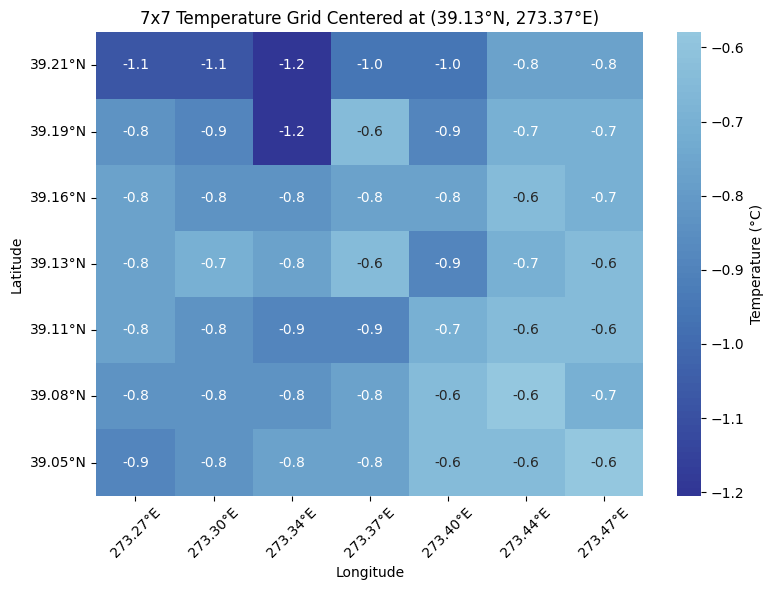

In [4]:
# Calculate n from the grid shape (assuming square grid)
n = temp_grid.shape[0]
half_size = (n - 1) // 2  # Center index, integer for odd n

# Convert temperatures to Celsius (optional, adjust based on your data)
temp_grid_celsius = temp_grid 

# Set up the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(temp_grid_celsius,
            annot=True,          # Show temperature values in each cell
            fmt='.1f',           # Format to 1 decimal place
            cmap='RdYlBu_r',     # Red (hot) to blue (cold), reversed
            cbar_kws={'label': 'Temperature (°C)'},  # Colorbar label
            center=0)            # Center colormap at 0°C


center_lat = lat_grid[half_size, half_size]
center_lon = lon_grid[half_size, half_size]


lat_labels = [f"{lat:.2f}°N" for lat in lat_grid[:, half_size]]
lon_labels = [f"{abs(lon):.2f}°{'W' if lon < 0 else 'E'}" for lon in lon_grid[half_size, :]]


plt.xticks(np.arange(n) + 0.5, lon_labels, rotation=45)
plt.yticks(np.arange(n) + 0.5, lat_labels, rotation=0)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"{n}x{n} Temperature Grid Centered at ({center_lat:.2f}°N, {abs(center_lon):.2f}°{'W' if center_lon < 0 else 'E'})")

plt.gca().invert_yaxis()
plt.tight_layout()

# Display the plot
plt.show()

In [5]:
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 6, 1)
data = "kbmg.csv"
df = pd.read_csv(data, quotechar='"', skipinitialspace=True, header=0, delimiter=',', engine='python')
df = df[df["CALL_SIGN"].str.strip() == "KBMG"]
dt_tmp = df[["DATE", "TMP"]]
dt_tmp["DATE"] = pd.to_datetime(dt_tmp["DATE"]).dt.round("h")
dt_tmp = dt_tmp.values
prev_time = None
clean_tmp = []
date_list = []
skip_val = "+9999,9"
for dt, tmp in dt_tmp:
    if dt >= start_date and dt <= end_date and dt != prev_time:
        prev_time = dt
        print(dt)
        if tmp.strip() == skip_val:
            continue
        new_tmp = float(int(tmp.strip().split(",")[0])/10)
        clean_tmp.append([dt, new_tmp])
        date_list.append(dt)
    
clean_tmp = np.array(clean_tmp)
obs = clean_tmp[:,1]
obs

C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\2325410424.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_tmp["DATE"] = pd.to_datetime(dt_tmp["DATE"]).dt.round("h")


2021-01-01 00:00:00
2021-01-01 01:00:00
2021-01-01 02:00:00
2021-01-01 03:00:00
2021-01-01 04:00:00
2021-01-01 05:00:00
2021-01-01 06:00:00
2021-01-01 07:00:00
2021-01-01 08:00:00
2021-01-01 09:00:00
2021-01-01 10:00:00
2021-01-01 11:00:00
2021-01-01 12:00:00
2021-01-01 13:00:00
2021-01-01 14:00:00
2021-01-01 15:00:00
2021-01-01 16:00:00
2021-01-01 17:00:00
2021-01-01 18:00:00
2021-01-01 19:00:00
2021-01-01 20:00:00
2021-01-01 21:00:00
2021-01-01 22:00:00
2021-01-01 23:00:00
2021-01-02 00:00:00
2021-01-02 01:00:00
2021-01-02 02:00:00
2021-01-02 03:00:00
2021-01-02 04:00:00
2021-01-02 05:00:00
2021-01-02 06:00:00
2021-01-02 07:00:00
2021-01-02 08:00:00
2021-01-02 09:00:00
2021-01-02 10:00:00
2021-01-02 11:00:00
2021-01-02 12:00:00
2021-01-02 13:00:00
2021-01-02 14:00:00
2021-01-02 15:00:00
2021-01-02 16:00:00
2021-01-02 17:00:00
2021-01-02 18:00:00
2021-01-02 19:00:00
2021-01-02 20:00:00
2021-01-02 21:00:00
2021-01-02 22:00:00
2021-01-02 23:00:00
2021-01-03 00:00:00
2021-01-03 01:00:00


array([-1.7, -2.2, -2.2, ..., 23.9, 23.3, 22.2],
      shape=(3624,), dtype=object)

In [6]:
sfc_or_prs = 'sfc' # sfc or prs
typeOfLevel = 'surface' if sfc_or_prs == 'sfc' else 'isobaricInhPa'
stepType = 'instant' # instant, max, or accum, but we only want instant
inp_dataset = []
#date_list = date_list[0:len(date_list)-1]
init_times = [0]
fcst_hours = range(0,25)
debugging = None
try:
    for current_date in date_list:
        print(current_date)
        debugging = current_date
        for init_h in init_times:
            print(init_h)
            init_time = datetime(current_date.year, current_date.month, current_date.day, init_h)
            if current_date.hour < 10:
                temp_hour = f'0{current_date.hour}'
            if current_date.day < 10:
                temp_day = f'0{current_date.day}'
            if current_date.month < 10:
                temp_month = f'0{current_date.month}'
            else:
                temp_hour = str(current_date.hour)
                temp_day = str(current_date.day)
                temp_month = str(current_date.month)
            if current_date.year == 2021 and current_date.month == 1 and current_date.day == 1:
                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/{str(current_date.year)}{temp_month}{temp_day}_f{temp_hour}_sfc.grib2"
            else:
                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/{str(current_date.year)}{temp_month}{temp_day}_00z_f{temp_hour}_sfc.grib2"
            ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
            inp_dataset.append(get_temp_grid_centered(ds, 3)[0])
except:
    print(debugging)
'''
for j in range(1,18):
    for i in range(0,25):
        if j < 10:
            if i < 10:
                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/2021010{j}_f0{i}_sfc.grib2"
                ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
                inp_dataset.append(get_temp_grid_centered(ds, 3)[0])
            else:
                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/2021010{j}_f{i}_sfc.grib2"
                ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
                inp_dataset.append(get_temp_grid_centered(ds, 3)[0])
        else:
            if i < 10:
                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/202101{j}_f0{i}_sfc.grib2"
                ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
                inp_dataset.append(get_temp_grid_centered(ds, 3)[0])
            else:
                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/202101{j}_f{i}_sfc.grib2"
                ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
                inp_dataset.append(get_temp_grid_centered(ds, 3)[0])
inp_dataset
'''

Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f00_sfc.grib2.5b7b6.idx' incompatible with GRIB file


2021-01-01 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f01_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f02_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f03_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f04_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f05_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f06_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f07_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f08_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file 'C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/hrrr_data/20210101_f09_sfc.grib2.5b7b6.idx' incompatible with GRIB file


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-01 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-02 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-03 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-04 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-05 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-06 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-07 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-08 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-09 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-10 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-11 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-12 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-13 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-14 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-15 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-16 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-17 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-18 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-19 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-20 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-21 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-22 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-23 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-24 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-25 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-26 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-27 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-28 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-29 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-30 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-01-31 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-01 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-02 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-03 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-04 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-05 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-06 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-07 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-08 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-09 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-10 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-11 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-12 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-13 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-14 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-15 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-16 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-17 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-18 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-19 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-20 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-21 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-22 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-23 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-24 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-25 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-26 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-27 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-02-28 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-01 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-02 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-03 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-04 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-05 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-06 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-07 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-08 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-09 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-10 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-11 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-12 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-13 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-14 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-15 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-16 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-17 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-18 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-19 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-20 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-21 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-22 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-23 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-24 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-25 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-26 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-27 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-28 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-29 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-30 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-03-31 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-01 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-02 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-03 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-04 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-05 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-06 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-07 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-08 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-09 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-10 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-11 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-12 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-13 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-14 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-15 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-16 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-17 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-18 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-19 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-20 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-21 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-22 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-23 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-24 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-25 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-26 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-27 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-28 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-29 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-04-30 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-01 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-02 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-03 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-04 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-05 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-06 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-07 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-08 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-09 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-10 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-11 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-12 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-13 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-14 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-15 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-16 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 03:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-17 23:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 01:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 02:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 21:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 22:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-18 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 19:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 20:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-19 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 04:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 05:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-20 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_

Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-21 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 10:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 11:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 13:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 14:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 15:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 16:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 17:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-22 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-23 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-24 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 18:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-25 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-26 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 09:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 12:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-27 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 06:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 07:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 08:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-28 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-29 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-30 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 00:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 01:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 02:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 03:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 04:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 05:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 06:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 07:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 08:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 09:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 10:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 11:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 12:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 13:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 14:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 15:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 16:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 17:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 18:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 19:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 20:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 21:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 22:00:00
0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-05-31 23:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
2021-06-01 00:00:00
0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


'\nfor j in range(1,18):\n    for i in range(0,25):\n        if j < 10:\n            if i < 10:\n                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/2021010{j}_f0{i}_sfc.grib2"\n                ds = xr.open_dataset(save_path, engine=\'cfgrib\', filter_by_keys={\'stepType\': stepType, \'typeOfLevel\': typeOfLevel})\n                inp_dataset.append(get_temp_grid_centered(ds, 3)[0])\n            else:\n                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/2021010{j}_f{i}_sfc.grib2"\n                ds = xr.open_dataset(save_path, engine=\'cfgrib\', filter_by_keys={\'stepType\': stepType, \'typeOfLevel\': typeOfLevel})\n                inp_dataset.append(get_temp_grid_centered(ds, 3)[0])\n        else:\n            if i < 10:\n                save_path = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/202101{j}_f0{i}_sfc.grib2"\n                ds = xr.open_dataset(save_path, engine=\'cfgrib\', filte

In [7]:
print(debugging)
print(len(inp_dataset))
print(obs.shape)

2021-06-01 00:00:00
3624
(3624,)


In [8]:
#Todo, make sure the output dataset alligns with the input dataset dates
out_dataset = obs
print(out_dataset.shape)
out_dataset
len(inp_dataset)

(3624,)


3624

Using device: cuda
Epoch [10/150], Train MSE: 83.5567, Train MAE: 7.0412, Test MSE: 76.6422, Test MAE: 6.6111
Epoch [20/150], Train MSE: 44.3845, Train MAE: 5.0841, Test MSE: 42.7668, Test MAE: 4.9930
Epoch [30/150], Train MSE: 46.7694, Train MAE: 5.3092, Test MSE: 46.4599, Test MAE: 5.2348
Epoch [40/150], Train MSE: 42.4836, Train MAE: 5.0703, Test MSE: 42.2012, Test MAE: 4.9961
Epoch [50/150], Train MSE: 42.2535, Train MAE: 5.0385, Test MSE: 41.8669, Test MAE: 4.9727
Epoch [60/150], Train MSE: 41.4102, Train MAE: 5.0322, Test MSE: 41.3965, Test MAE: 4.9808
Epoch [70/150], Train MSE: 40.6229, Train MAE: 4.9712, Test MSE: 40.6673, Test MAE: 4.9209
Epoch [80/150], Train MSE: 39.8122, Train MAE: 4.9329, Test MSE: 40.1084, Test MAE: 4.8983
Epoch [90/150], Train MSE: 39.1428, Train MAE: 4.8979, Test MSE: 39.6380, Test MAE: 4.8662
Epoch [100/150], Train MSE: 38.6883, Train MAE: 4.8743, Test MSE: 39.3237, Test MAE: 4.8394
Epoch [110/150], Train MSE: 38.4383, Train MAE: 4.8666, Test MSE: 39.2

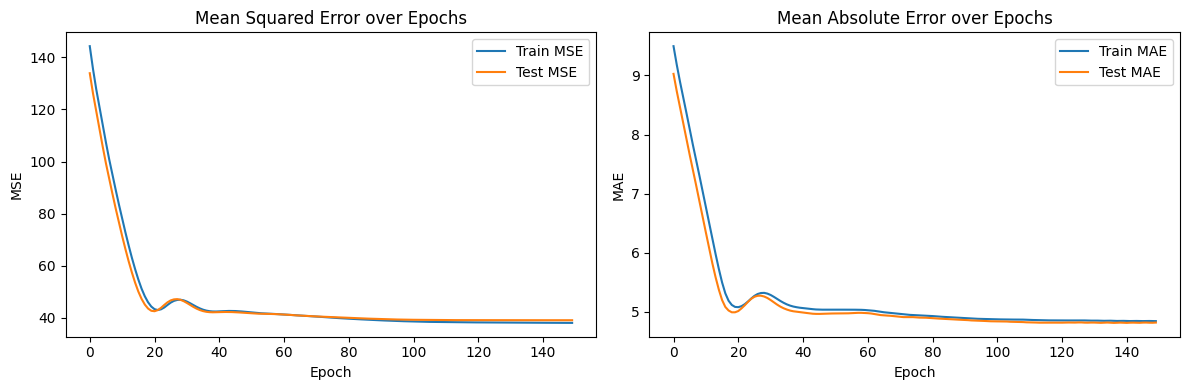

In [11]:
x = np.array(inp_dataset) #shape (25,7,7)
y = np.array([float(val) for val in out_dataset]) #shape (25,)

X = torch.FloatTensor(x)
Y = torch.FloatTensor(y)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Check GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")  # Confirm GPU is being used

# Move all data to the GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(7 * 7, 64),  # Input: 49 (7x7 flattened) -> 64
            nn.ReLU(),
            nn.Linear(64, 32),     # Hidden layer: 64 -> 32
            nn.ReLU(),
            nn.Linear(32, 1)       # Output: 32 -> 1 (regression)
        )
    
    def forward(self, x):
        x = self.flatten(x)  # Flatten from (batch_size, 7, 7) to (batch_size, 49)
        return self.network(x)

# Initialize the model and move it to the GPU
model = SimpleNN().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 150

# Lists to store metrics
train_losses = []
train_maes = []
test_losses = []
test_maes = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    outputs = model(X_train)  # Forward pass on GPU
    loss = criterion(outputs, y_train.unsqueeze(1))  # Match shapes: (batch_size, 1)
    mae = torch.mean(torch.abs(outputs - y_train.unsqueeze(1))).item()  # MAE as scalar
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store training metrics
    train_losses.append(loss.item())
    train_maes.append(mae)
    
    # Evaluation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test.unsqueeze(1)).item()
        test_mae = torch.mean(torch.abs(test_outputs - y_test.unsqueeze(1))).item()
        test_losses.append(test_loss)
        test_maes.append(test_mae)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train MSE: {loss.item():.4f}, Train MAE: {mae:.4f}, "
              f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Plotting results
plt.figure(figsize=(12, 4))

# Plot Mean Squared Error
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train MSE')
plt.plot(test_losses, label='Test MSE')
plt.title('Mean Squared Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(test_maes, label='Test MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()
#calculate loss, accuracy for each epoch and then plot them

In [32]:
from numpy import absolute


Absulute_err = []
inp_exe = [datetime(2021,6,18),datetime(2021,6,19),datetime(2022, 12, 22),datetime(2022, 12, 22),datetime(2023, 3, 31),datetime(2023, 4, 1)]
i = 0
while i < len(inp_exe) - 1: 
    curr_date = inp_exe[i]
    end_date = inp_exe[i+1]
    while curr_date <= end_date:
        for j in range(0,24):
            if j >= 10:
                hour = f'{j}'
            elif j < 10:
                hour = f'0{j}'
            if curr_date.month < 10:
                month =  f'0{curr_date.month}'
            elif curr_date.month >= 10:
                month =  f'{curr_date.month}'
            if curr_date.day < 10:
                day =  f'0{curr_date.day}'
            elif curr_date.day >= 10:
                day =  f'{curr_date.day}'
            year = str(curr_date.year)
            example_input = f"C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/mod_testing/{year}{month}{day}_00z_f{hour}_sfc.grib2"
            ds = xr.open_dataset(example_input, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
            inp_ex = get_temp_grid_centered(ds, 3)[0]
            final_example = np.array(inp_ex)
            print(final_example)
            input_tensor = torch.FloatTensor(final_example).unsqueeze(0).to(device)
            model.eval()
            with torch.no_grad():
                output = model(input_tensor)
                predicted_value = output.item()
            
            print(datetime(curr_date.year, curr_date.month, curr_date.day, j, 0, 0))
            print(f"Predicted value: {predicted_value}")
            actual_tmp_df = df[["DATE", "TMP"]]
            actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")
            tmp_val = actual_tmp_df[actual_tmp_df["DATE"] == datetime(curr_date.year, curr_date.month, curr_date.day, j, 0, 0)].iat[0,1]
            real_tmp_val = float(int(tmp_val.strip().split(",")[0])/10)
            print(real_tmp_val)
            Absulute_err.append(abs(float(predicted_value)-real_tmp_val))

        curr_date += timedelta(days=1)
    i += 2

print(Absulute_err)
print(sum(Absulute_err)/len(Absulute_err))




'''
example_input = "C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/mod_testing/20210301_00z_f00_sfc.grib2"
ds = xr.open_dataset(example_input, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
inp_ex.append(get_temp_grid_centered(ds, 3)[0])
final_example = np.array(inp_ex)
print(final_example)
input_tensor = torch.FloatTensor(final_example).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_value = output.item()

print(f"Predicted value: {predicted_value}")
'''

c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[27.722992 27.222992 27.035492 26.972992 27.160492 27.722992 27.972992]
 [27.472992 27.222992 26.910492 26.535492 27.347992 27.347992 27.347992]
 [27.722992 27.347992 26.785492 26.972992 26.847992 27.285492 27.035492]
 [27.035492 27.785492 27.285492 27.222992 27.410492 27.597992 27.347992]
 [27.222992 27.347992 27.160492 27.347992 27.035492 27.660492 27.722992]
 [27.535492 27.597992 28.097992 27.597992 27.222992 27.597992 26.785492]
 [27.597992 28.035492 28.285492 27.910492 27.535492 27.722992 27.222992]]
2021-06-18 00:00:00
Predicted value: 38.105812072753906
28.3


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[25.31601 24.56601 24.06601 23.94101 24.50351 25.31601 25.50351]
 [24.94101 24.87851 24.87851 24.44101 25.06601 25.00351 24.94101]
 [25.12851 24.94101 24.56601 24.81601 24.44101 25.00351 24.87851]
 [24.62851 25.19101 24.75351 24.81601 24.87851 25.06601 25.12851]
 [24.81601 24.75351 24.37851 24.75351 24.50351 25.12851 25.37851]
 [25.00351 24.81601 25.00351 24.75351 24.56601 25.06601 24.44101]
 [25.00351 25.12851 25.06601 24.87851 24.69101 25.06601 24.81601]]
2021-06-18 01:00:00
Predicted value: 34.60355758666992
23.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[22.959991 22.522491 21.834991 21.772491 22.522491 23.272491 23.334991]
 [22.709991 22.897491 22.897491 22.522491 22.897491 22.834991 23.084991]
 [22.897491 23.147491 22.522491 22.897491 22.209991 22.772491 22.647491]
 [22.647491 23.209991 22.834991 22.709991 22.772491 22.897491 22.897491]
 [22.897491 22.647491 22.334991 22.772491 22.522491 23.022491 23.397491]
 [23.022491 22.834991 23.022491 22.709991 22.522491 23.147491 22.397491]
 [22.959991 23.147491 22.959991 22.772491 22.647491 23.022491 23.084991]]
2021-06-18 02:00:00
Predicted value: 31.759742736816406
22.2


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[21.773132 21.335632 20.585632 20.460632 21.335632 21.898132 21.710632]
 [21.585632 21.835632 21.710632 21.335632 21.523132 21.460632 21.898132]
 [21.773132 22.148132 21.523132 21.773132 20.773132 21.335632 21.398132]
 [21.585632 22.148132 21.960632 21.710632 21.398132 21.273132 21.523132]
 [21.898132 21.648132 21.523132 21.835632 21.398132 21.523132 22.023132]
 [21.898132 22.210632 22.273132 21.835632 21.523132 22.085632 21.273132]
 [21.773132 22.210632 22.210632 21.898132 21.835632 22.023132 22.210632]]
2021-06-18 03:00:00
Predicted value: 30.221044540405273
21.1


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[20.908356 20.533356 19.783356 19.783356 20.533356 20.845856 20.595856]
 [20.783356 21.095856 20.908356 20.658356 20.533356 20.533356 21.158356]
 [20.845856 21.408356 20.845856 20.970856 19.783356 20.408356 20.658356]
 [20.783356 21.220856 21.283356 20.908356 20.470856 20.220856 20.533356]
 [21.095856 20.783356 20.783356 21.095856 20.595856 20.595856 21.095856]
 [21.220856 21.595856 21.595856 21.158356 20.720856 21.345856 20.595856]
 [21.158356 21.533356 21.595856 21.220856 21.220856 21.345856 21.720856]]
2021-06-18 04:00:00
Predicted value: 29.170391082763672
20.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[20.37674 19.87674 19.18924 19.25174 19.75174 19.93924 19.68924]
 [20.12674 20.50174 20.31424 20.12674 19.68924 19.62674 20.37674]
 [20.12674 20.81424 20.18924 20.31424 18.93924 19.50174 19.81424]
 [20.06424 20.43924 20.68924 20.18924 19.50174 19.25174 19.56424]
 [20.43924 19.93924 20.18924 20.43924 19.87674 19.62674 20.06424]
 [20.43924 21.00174 21.06424 20.50174 20.12674 20.75174 20.06424]
 [20.37674 20.93924 21.06424 20.62674 20.68924 20.81424 21.25174]]
2021-06-18 05:00:00
Predicted value: 28.214611053466797
18.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[20.007996 19.507996 18.820496 19.007996 19.257996 19.257996 19.070496]
 [19.757996 20.257996 19.945496 19.820496 19.070496 19.070496 20.132996]
 [19.695496 20.570496 19.945496 20.070496 18.382996 18.882996 19.507996]
 [19.695496 20.007996 20.382996 19.882996 19.007996 18.632996 18.945496]
 [20.132996 19.570496 19.945496 20.132996 19.507996 19.007996 19.445496]
 [20.132996 20.820496 20.882996 20.257996 19.757996 20.257996 19.570496]
 [20.007996 20.757996 20.945496 20.382996 20.382996 20.445496 20.757996]]
2021-06-18 06:00:00
Predicted value: 27.705089569091797
20.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[20.342743 19.655243 18.905243 19.092743 19.592743 19.342743 19.217743]
 [20.092743 20.342743 19.967743 19.842743 18.905243 19.092743 20.030243]
 [20.092743 20.717743 20.155243 20.030243 18.155243 18.842743 19.467743]
 [20.030243 20.405243 20.592743 19.905243 19.030243 18.530243 18.905243]
 [20.405243 19.967743 20.217743 20.092743 19.217743 19.155243 19.655243]
 [20.530243 20.967743 21.030243 20.405243 19.717743 20.280243 19.842743]
 [20.530243 21.092743 21.217743 20.655243 20.592743 20.780243 21.030243]]
2021-06-18 07:00:00
Predicted value: 27.910959243774414
20.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[20.64621 19.89621 19.14621 19.45871 20.08371 19.45871 19.27121]
 [20.39621 20.52121 20.14621 20.08371 19.02121 19.20871 20.02121]
 [20.33371 20.83371 20.33371 20.27121 18.33371 19.02121 19.77121]
 [20.20871 20.64621 20.77121 20.02121 19.08371 18.70871 19.27121]
 [20.52121 20.14621 20.45871 20.20871 19.27121 19.33371 19.77121]
 [20.64621 20.95871 21.08371 20.39621 19.64621 20.20871 19.83371]
 [20.64621 21.08371 21.20871 20.58371 20.39621 20.64621 20.89621]]
2021-06-18 08:00:00
Predicted value: 28.10472297668457
21.1


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[20.044281 19.419281 18.669281 19.106781 19.544281 18.794281 18.731781]
 [20.169281 20.106781 19.669281 19.794281 18.544281 18.544281 19.481781]
 [20.044281 20.794281 20.294281 19.919281 17.794281 18.356781 19.044281]
 [20.106781 20.356781 20.731781 20.169281 18.481781 18.106781 18.481781]
 [20.481781 19.981781 20.481781 20.294281 19.356781 18.544281 18.794281]
 [20.481781 21.106781 21.294281 20.419281 19.794281 19.794281 19.294281]
 [20.419281 21.169281 21.294281 20.606781 20.544281 20.356781 20.419281]]
2021-06-18 09:00:00
Predicted value: 27.783451080322266
22.2


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[20.736969 19.736969 19.049469 19.549469 20.049469 19.236969 19.236969]
 [20.486969 20.736969 20.236969 20.174469 19.049469 19.174469 20.361969]
 [20.049469 20.549469 20.236969 20.111969 18.611969 19.174469 19.924469]
 [20.049469 20.174469 20.361969 19.861969 19.236969 19.049469 19.611969]
 [20.486969 19.736969 20.174469 20.111969 19.549469 19.674469 19.986969]
 [20.361969 20.861969 21.174469 20.549469 20.111969 20.799469 20.424469]
 [20.486969 21.174469 21.549469 21.174469 21.049469 21.174469 21.299469]]
2021-06-18 10:00:00
Predicted value: 28.228160858154297
22.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[20.833038 20.208038 19.708038 20.020538 20.583038 20.083038 20.270538]
 [20.708038 20.833038 20.520538 20.520538 19.833038 20.020538 20.708038]
 [20.583038 21.083038 20.770538 20.770538 19.333038 19.958038 20.458038]
 [20.520538 20.833038 21.083038 20.708038 20.020538 19.770538 19.958038]
 [20.895538 20.583038 20.895538 20.833038 20.083038 20.145538 20.395538]
 [21.020538 21.333038 21.645538 21.145538 20.520538 20.895538 20.583038]
 [21.208038 21.520538 21.770538 21.458038 21.208038 21.333038 21.458038]]
2021-06-18 11:00:00
Predicted value: 28.92047119140625
21.7


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[23.735168 23.110168 22.235168 22.172668 23.110168 23.610168 23.672668]
 [23.360168 23.547668 22.985168 22.610168 23.110168 23.172668 23.360168]
 [23.485168 23.735168 23.297668 23.297668 22.735168 22.985168 23.047668]
 [23.235168 23.922668 23.922668 23.610168 23.110168 22.985168 22.922668]
 [23.610168 23.485168 23.610168 23.672668 22.735168 23.235168 23.360168]
 [23.985168 23.922668 24.235168 23.797668 23.172668 23.610168 23.172668]
 [24.047668 24.110168 24.360168 24.110168 23.735168 23.860168 23.860168]]
2021-06-18 12:00:00
Predicted value: 32.6237907409668
22.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[27.035309 26.347809 25.410309 25.285309 26.410309 27.410309 27.472809]
 [26.535309 26.847809 26.410309 25.785309 26.660309 26.910309 26.972809]
 [26.910309 27.035309 26.597809 26.785309 26.347809 26.785309 26.410309]
 [26.410309 27.410309 27.410309 27.097809 26.722809 26.910309 26.597809]
 [26.972809 26.910309 26.910309 27.035309 26.035309 27.160309 27.035309]
 [27.222809 27.035309 27.597809 27.035309 26.472809 27.222809 26.847809]
 [27.160309 27.160309 27.535309 27.160309 26.910309 27.347809 27.847809]]
2021-06-18 13:00:00
Predicted value: 37.31352615356445
25.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[29.508514 28.571014 27.508514 27.383514 29.071014 30.446014 31.008514]
 [28.883514 29.258514 28.883514 28.258514 29.508514 29.696014 30.321014]
 [29.508514 29.508514 29.446014 29.446014 29.071014 29.571014 29.508514]
 [29.321014 30.321014 30.071014 29.946014 29.383514 29.946014 29.508514]
 [29.571014 29.633514 29.571014 29.821014 28.696014 30.446014 30.633514]
 [30.321014 30.383514 31.196014 30.008514 29.383514 30.758514 30.133514]
 [30.696014 30.821014 30.508514 30.508514 30.071014 30.383514 31.071014]]
2021-06-18 14:00:00
Predicted value: 41.29975509643555
26.1


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[31.914062 30.789062 29.351562 29.226562 30.789062 33.101562 33.414062]
 [31.351562 31.851562 30.914062 30.164062 31.726562 32.164062 32.601562]
 [32.164062 32.539062 31.539062 31.414062 31.226562 31.789062 31.726562]
 [31.851562 32.789062 32.726562 32.101562 31.851562 32.664062 31.914062]
 [32.726562 32.601562 32.289062 32.539062 31.101562 32.914062 33.226562]
 [33.539062 33.476562 33.976562 32.664062 32.101562 33.476562 32.226562]
 [33.476562 33.664062 34.039062 33.101562 32.851562 33.476562 33.976562]]
2021-06-18 15:00:00
Predicted value: 44.64672088623047
28.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[34.208008 33.020508 31.083008 31.020508 33.083008 35.270508 36.083008]
 [33.645508 34.083008 33.270508 32.270508 34.020508 34.208008 35.083008]
 [34.333008 34.645508 33.770508 34.145508 33.083008 34.020508 33.958008]
 [33.833008 35.333008 35.208008 34.520508 34.583008 34.958008 34.520508]
 [34.708008 34.645508 34.520508 34.645508 33.708008 35.583008 35.833008]
 [35.645508 35.708008 36.395508 35.020508 34.145508 35.833008 34.583008]
 [35.833008 35.895508 36.270508 35.458008 35.020508 35.708008 36.020508]]
2021-06-18 16:00:00
Predicted value: 47.81117248535156
29.4


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[35.505554 34.255554 32.130554 32.068054 34.380554 36.693054 37.693054]
 [34.943054 35.443054 34.505554 33.380554 35.380554 35.630554 36.693054]
 [35.568054 36.068054 35.130554 35.443054 34.380554 35.443054 35.568054]
 [35.130554 36.755554 36.568054 36.005554 36.130554 36.568054 36.318054]
 [36.130554 36.005554 35.755554 36.005554 35.255554 37.130554 37.630554]
 [37.005554 37.130554 37.943054 36.443054 35.755554 37.318054 36.068054]
 [37.255554 37.318054 37.880554 36.880554 36.505554 37.130554 37.443054]]
2021-06-18 17:00:00
Predicted value: 49.748329162597656
31.7


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[36.07251 34.76001 32.51001 32.44751 34.88501 37.19751 37.69751]
 [35.51001 36.01001 35.01001 33.88501 35.94751 36.26001 37.19751]
 [36.19751 36.69751 35.69751 36.07251 34.88501 36.13501 36.26001]
 [35.76001 37.44751 37.19751 36.63501 36.88501 37.32251 37.07251]
 [36.76001 36.63501 36.32251 36.63501 35.94751 37.94751 38.44751]
 [37.63501 37.19751 38.32251 37.19751 36.51001 38.07251 36.76001]
 [37.88501 38.07251 38.32251 37.57251 37.26001 37.94751 38.13501]]
2021-06-18 18:00:00
Predicted value: 50.5456428527832
32.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[36.26001 34.94751 32.63501 32.51001 34.94751 36.57251 37.38501]
 [35.51001 36.26001 35.13501 33.94751 36.07251 36.38501 37.26001]
 [36.44751 36.88501 35.76001 36.19751 35.01001 36.32251 36.38501]
 [35.94751 37.57251 36.32251 35.94751 36.88501 37.51001 37.26001]
 [37.01001 36.76001 36.26001 36.19751 36.13501 38.07251 38.44751]
 [37.69751 37.38501 38.69751 37.07251 36.01001 38.01001 36.69751]
 [38.01001 38.07251 38.32251 37.82251 36.82251 38.07251 38.13501]]
2021-06-18 19:00:00
Predicted value: 50.520896911621094
33.3


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[36.07251 34.82251 32.57251 32.51001 34.82251 37.19751 38.07251]
 [35.57251 36.07251 35.01001 33.82251 36.01001 36.38501 37.19751]
 [36.32251 36.76001 35.69751 36.07251 34.94751 36.32251 36.38501]
 [35.82251 37.57251 37.13501 36.63501 36.94751 37.38501 37.19751]
 [36.94751 36.76001 36.32251 36.63501 36.07251 37.94751 38.32251]
 [37.69751 37.32251 37.38501 37.26001 36.57251 37.88501 36.69751]
 [36.82251 37.07251 37.63501 37.07251 36.51001 37.76001 37.94751]]
2021-06-18 20:00:00
Predicted value: 50.43869400024414
33.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[35.19751 33.94751 31.82251 31.76001 34.01001 36.32251 37.26001]
 [34.69751 35.26001 34.19751 33.01001 35.13501 35.51001 36.32251]
 [35.44751 35.94751 34.88501 35.19751 34.13501 35.44751 35.57251]
 [35.07251 36.13501 36.19751 35.76001 36.07251 36.38501 36.19751]
 [35.19751 35.01001 35.44751 35.69751 35.19751 36.88501 37.13501]
 [34.44751 35.63501 36.51001 36.32251 35.69751 37.01001 35.76001]
 [36.07251 35.63501 36.57251 35.69751 36.38501 37.01001 36.94751]]
2021-06-18 21:00:00
Predicted value: 49.12187957763672
33.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[34.19751 33.07251 31.19751 31.19751 33.13501 35.26001 36.13501]
 [33.76001 34.19751 33.32251 32.19751 34.13501 34.57251 35.26001]
 [34.44751 34.82251 33.82251 34.13501 33.19751 34.51001 34.57251]
 [34.01001 35.57251 35.07251 34.63501 34.94751 35.26001 35.13501]
 [34.94751 34.76001 34.32251 34.63501 34.07251 35.69751 36.01001]
 [35.69751 35.57251 36.01001 35.19751 34.57251 35.76001 34.57251]
 [35.63501 35.26001 35.69751 35.51001 35.19751 35.76001 35.69751]]
2021-06-18 22:00:00
Predicted value: 47.91975402832031
33.3


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[28.76001 28.38501 27.57251 27.63501 28.94751 31.01001 31.69751]
 [28.57251 29.07251 29.07251 28.51001 29.88501 30.51001 31.01001]
 [29.07251 29.57251 29.26001 29.76001 29.19751 30.32251 30.44751]
 [28.76001 30.07251 30.01001 30.13501 30.38501 30.69751 30.82251]
 [29.69751 29.94751 29.69751 30.13501 29.88501 31.13501 31.26001]
 [30.63501 30.76001 31.13501 30.69751 30.38501 31.07251 30.32251]
 [31.01001 31.32251 31.38501 31.01001 30.76001 31.32251 31.07251]]
2021-06-18 23:00:00
Predicted value: 41.79942321777344
31.7


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[30.19754 29.57254 28.19754 27.94754 29.26004 30.76004 31.32254]
 [29.88504 30.51004 29.76004 28.63504 29.51004 29.44754 29.51004]
 [30.76004 30.88504 30.01004 30.01004 28.94754 29.13504 29.13504]
 [30.01004 31.32254 31.01004 30.57254 30.38504 30.07254 30.07254]
 [29.13504 29.57254 30.01004 30.94754 30.63504 31.32254 31.01004]
 [28.19754 28.19754 29.07254 30.82254 31.69754 31.88504 30.19754]
 [29.13504 28.07254 27.82254 29.13504 30.69754 31.51004 31.76004]]
2021-06-19 00:00:00
Predicted value: 41.421627044677734
31.1


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[28.147552 27.772552 26.710052 26.272552 27.210052 28.585052 29.272552]
 [27.772552 27.897552 27.460052 26.647552 26.960052 27.085052 27.710052]
 [27.460052 27.710052 27.022552 27.022552 26.460052 26.897552 27.335052]
 [26.772552 27.210052 26.772552 26.585052 26.647552 26.960052 27.397552]
 [26.397552 26.460052 26.147552 26.272552 26.147552 26.710052 26.772552]
 [26.085052 25.897552 25.960052 26.022552 26.085052 26.210052 25.960052]
 [26.022552 25.835052 25.647552 25.710052 25.897552 26.210052 26.210052]]
2021-06-19 01:00:00
Predicted value: 37.32240676879883
29.4


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[27.379425 26.941925 25.941925 25.754425 26.816925 27.754425 27.629425]
 [27.066925 27.191925 26.629425 25.879425 25.816925 25.566925 25.566925]
 [26.066925 26.004425 25.566925 25.504425 25.254425 25.504425 25.566925]
 [25.941925 26.254425 25.816925 25.566925 25.566925 25.816925 26.004425]
 [26.004425 25.941925 25.629425 25.629425 25.441925 26.004425 26.254425]
 [25.879425 25.629425 25.691925 25.691925 25.629425 25.941925 25.754425]
 [26.816925 25.504425 25.379425 25.504425 25.566925 25.941925 25.941925]]
2021-06-19 02:00:00
Predicted value: 36.20645523071289
29.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[26.525452 26.150452 25.212952 24.962952 26.025452 26.962952 26.962952]
 [26.275452 26.587952 26.150452 25.587952 25.837952 24.837952 24.900452]
 [26.337952 25.025452 24.837952 24.775452 24.400452 24.587952 24.587952]
 [24.900452 25.337952 25.025452 24.775452 25.087952 25.337952 25.462952]
 [25.150452 25.150452 24.837952 25.087952 25.025452 24.712952 24.775452]
 [25.337952 25.087952 24.775452 24.650452 24.462952 24.587952 24.462952]
 [27.025452 25.275452 24.712952 24.587952 24.650452 25.087952 25.087952]]
2021-06-19 03:00:00
Predicted value: 35.22598648071289
23.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[25.965698 25.653198 24.715698 24.528198 25.465698 26.028198 26.028198]
 [25.965698 26.028198 25.653198 24.965698 25.028198 24.715698 24.965698]
 [26.153198 25.778198 24.465698 24.903198 23.840698 24.278198 24.090698]
 [24.903198 25.090698 24.278198 24.465698 24.340698 24.528198 24.528198]
 [24.840698 24.340698 23.653198 23.903198 23.778198 23.840698 23.653198]
 [24.403198 23.653198 23.403198 23.403198 23.528198 23.653198 23.528198]
 [25.028198 23.590698 23.215698 23.340698 23.465698 23.715698 23.715698]]
2021-06-19 04:00:00
Predicted value: 34.15522766113281
21.1


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[25.077972 24.702972 23.890472 23.577972 24.202972 24.890472 24.952972]
 [24.827972 25.140472 24.702972 24.015472 24.140472 24.077972 24.265472]
 [25.077972 25.015472 23.952972 24.265472 23.452972 23.890472 24.265472]
 [24.515472 24.577972 24.077972 24.202972 24.265472 24.452972 24.515472]
 [24.265472 24.077972 23.702972 23.890472 23.952972 24.140472 24.077972]
 [24.265472 23.765472 23.702972 23.702972 23.640472 23.827972 23.765472]
 [24.952972 23.827972 23.577972 23.515472 23.640472 23.952972 23.827972]]
2021-06-19 05:00:00
Predicted value: 33.64304733276367
999.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[24.237  23.987  23.362  23.0495 23.987  24.9245 25.1745]
 [24.0495 24.2995 24.112  23.612  23.9245 24.0495 24.612 ]
 [24.487  24.487  23.5495 23.737  23.237  24.112  24.362 ]
 [23.737  23.9245 23.487  23.612  23.612  24.112  24.2995]
 [23.6745 23.5495 23.2995 23.4245 23.362  23.6745 23.862 ]
 [23.737  23.362  23.237  23.1745 23.237  23.487  23.4245]
 [24.7995 23.6745 23.1745 23.1745 23.2995 23.612  23.6745]]
2021-06-19 06:00:00
Predicted value: 33.16519546508789
999.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[24.667114 24.417114 23.542114 23.542114 24.354614 25.104614 25.167114]
 [24.729614 24.917114 24.667114 24.167114 24.042114 24.354614 24.604614]
 [24.792114 25.104614 24.417114 24.542114 23.979614 24.167114 24.354614]
 [23.667114 23.917114 23.729614 24.229614 24.229614 24.292114 24.354614]
 [23.792114 23.729614 24.104614 24.042114 23.792114 24.104614 24.042114]
 [23.854614 23.854614 23.542114 23.479614 23.479614 23.604614 23.417114]
 [24.917114 24.479614 23.479614 23.479614 23.542114 23.792114 23.729614]]
2021-06-19 07:00:00
Predicted value: 33.647769927978516
999.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[24.033539 23.783539 23.158539 23.158539 23.971039 24.408539 24.721039]
 [23.908539 24.158539 23.971039 23.658539 23.908539 24.033539 24.346039]
 [24.158539 24.346039 23.846039 23.908539 23.596039 23.846039 24.158539]
 [23.033539 23.533539 23.596039 23.533539 23.658539 23.846039 23.971039]
 [23.221039 22.971039 23.408539 23.221039 23.158539 23.596039 23.596039]
 [23.096039 23.658539 22.846039 22.783539 22.783539 23.033539 23.033539]
 [24.096039 23.846039 22.783539 22.783539 22.908539 23.158539 23.221039]]
2021-06-19 08:00:00
Predicted value: 32.95244216918945
21.1


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[24.41272 24.03772 23.28772 23.10022 23.85022 24.35022 24.41272]
 [24.16272 24.41272 24.10022 23.60022 23.91272 23.91272 23.97522]
 [24.41272 24.53772 24.03772 24.03772 23.66272 23.85022 23.91272]
 [23.78772 24.28772 23.91272 23.60022 23.66272 23.85022 23.91272]
 [23.85022 23.22522 23.60022 23.41272 23.16272 23.53772 23.53772]
 [23.66272 23.60022 23.10022 23.03772 22.91272 22.97522 22.91272]
 [24.41272 23.85022 22.97522 23.10022 23.10022 23.41272 23.28772]]
2021-06-19 09:00:00
Predicted value: 33.03883743286133
21.1


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[23.56076 23.31076 22.74826 22.68576 23.24826 23.93576 24.18576]
 [23.43576 23.74826 23.56076 23.31076 23.43576 23.74826 23.81076]
 [23.68576 23.87326 23.62326 23.81076 23.43576 23.68576 23.68576]
 [23.31076 23.81076 23.68576 23.43576 23.37326 23.56076 23.62326]
 [23.31076 23.18576 23.31076 23.18576 22.87326 23.24826 23.24826]
 [23.31076 23.31076 22.56076 22.68576 22.56076 22.68576 22.62326]
 [23.74826 23.49826 22.56076 22.62326 22.68576 22.87326 22.74826]]
2021-06-19 10:00:00
Predicted value: 32.499114990234375
20.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[23.201141 22.888641 22.326141 22.263641 22.888641 23.513641 23.513641]
 [23.076141 23.138641 22.951141 22.638641 22.951141 23.013641 23.076141]
 [23.513641 23.513641 23.013641 23.013641 22.576141 22.888641 22.951141]
 [23.388641 23.826141 23.388641 22.888641 22.763641 22.888641 23.013641]
 [23.576141 23.451141 23.138641 22.888641 22.638641 23.013641 22.951141]
 [23.701141 23.513641 23.076141 22.451141 22.388641 22.451141 22.388641]
 [23.763641 23.638641 22.513641 22.513641 22.451141 22.576141 22.576141]]
2021-06-19 11:00:00
Predicted value: 31.991838455200195
20.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[19.638763 19.326263 18.951263 18.888763 19.138763 19.513763 19.451263]
 [19.451263 19.451263 19.263763 19.076263 19.201263 19.201263 19.013763]
 [19.576263 19.513763 19.138763 19.076263 19.013763 19.138763 19.013763]
 [19.388763 19.513763 19.201263 19.013763 18.951263 19.076263 18.951263]
 [19.451263 19.201263 19.013763 18.951263 18.826263 18.951263 18.826263]
 [19.388763 19.076263 19.013763 18.951263 18.951263 19.013763 18.888763]
 [19.388763 19.263763 19.076263 19.138763 19.138763 19.326263 19.326263]]
2021-06-19 12:00:00
Predicted value: 26.76769256591797
18.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[19.485748 19.173248 18.860748 18.673248 19.048248 19.423248 19.298248]
 [19.548248 19.360748 19.235748 18.923248 19.235748 19.235748 19.048248]
 [19.610748 19.423248 19.110748 19.110748 19.298248 19.360748 19.173248]
 [19.235748 19.485748 19.048248 18.923248 19.110748 19.423248 19.173248]
 [19.298248 19.110748 18.860748 18.798248 18.985748 19.360748 18.985748]
 [19.235748 18.985748 18.985748 19.110748 19.048248 19.360748 19.110748]
 [19.548248 19.173248 18.860748 19.110748 19.485748 19.485748 19.360748]]
2021-06-19 13:00:00
Predicted value: 26.77166748046875
18.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[20.162445 19.662445 19.537445 19.787445 20.162445 20.849945 20.412445]
 [20.412445 20.349945 20.287445 19.599945 20.349945 20.037445 20.224945]
 [20.224945 20.287445 19.662445 19.787445 19.849945 20.224945 20.162445]
 [20.037445 20.224945 19.662445 19.599945 19.849945 20.162445 20.287445]
 [20.037445 20.099945 19.724945 19.537445 19.599945 20.099945 20.037445]
 [20.349945 19.787445 19.849945 19.537445 19.537445 19.849945 19.724945]
 [20.224945 20.099945 19.787445 19.787445 19.912445 20.162445 19.912445]]
2021-06-19 14:00:00
Predicted value: 27.859699249267578
20.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[21.844421 21.906921 21.594421 21.531921 22.219421 22.469421 22.219421]
 [21.969421 22.406921 22.344421 22.031921 22.344421 22.281921 21.781921]
 [22.406921 22.344421 22.031921 22.281921 22.031921 22.281921 22.344421]
 [22.469421 22.594421 22.094421 21.844421 22.156921 22.469421 22.531921]
 [22.594421 22.344421 21.781921 21.656921 21.594421 22.344421 22.469421]
 [22.719421 22.281921 22.344421 21.906921 22.031921 22.406921 22.406921]
 [22.969421 22.844421 22.469421 22.281921 22.469421 22.719421 22.719421]]
2021-06-19 15:00:00
Predicted value: 30.96780776977539
21.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[23.524963 23.399963 22.962463 22.774963 23.212463 22.774963 22.212463]
 [21.899963 21.399963 21.649963 21.149963 21.524963 21.337463 21.337463]
 [22.962463 21.087463 20.899963 21.149963 21.149963 21.649963 23.649963]
 [23.649963 20.962463 20.712463 20.837463 22.587463 24.024963 23.587463]
 [22.462463 20.837463 20.837463 21.274963 22.524963 23.837463 23.462463]
 [21.274963 20.837463 21.212463 21.649963 23.212463 23.774963 23.149963]
 [24.337463 22.337463 21.524963 21.649963 23.899963 24.087463 24.087463]]
2021-06-19 16:00:00
Predicted value: 31.08966064453125
19.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[25.460327 25.460327 24.085327 24.397827 25.147827 27.085327 26.397827]
 [25.147827 25.085327 25.022827 23.960327 25.710327 25.460327 25.772827]
 [25.210327 25.335327 24.835327 25.522827 25.210327 25.085327 25.710327]
 [25.522827 25.710327 25.460327 24.772827 25.147827 26.147827 26.022827]
 [24.960327 25.085327 25.085327 24.397827 24.210327 25.960327 26.085327]
 [26.147827 26.397827 26.835327 24.835327 25.522827 25.835327 25.835327]
 [27.147827 27.647827 27.022827 26.460327 27.210327 27.335327 27.522827]]
2021-06-19 17:00:00
Predicted value: 35.69363021850586
21.7


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[27.06961 27.50711 25.69461 26.00711 28.00711 29.94461 29.94461]
 [27.25711 27.69461 27.81961 27.00711 28.56961 28.56961 28.56961]
 [27.56961 28.00711 27.31961 28.88211 28.13211 28.75711 28.69461]
 [27.19461 27.63211 27.38211 26.69461 27.94461 28.56961 28.31961]
 [27.31961 27.19461 26.13211 26.19461 25.81961 27.75711 27.31961]
 [27.88211 27.94461 28.31961 26.69461 26.63211 27.44461 27.50711]
 [28.56961 29.13211 28.63211 28.13211 28.44461 28.88211 29.00711]]
2021-06-19 18:00:00
Predicted value: 38.74945831298828
25.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[28.931976 28.431976 27.431976 27.744476 29.869476 31.494476 31.306976]
 [28.494476 29.306976 29.744476 29.369476 30.869476 30.556976 30.369476]
 [28.681976 29.369476 29.056976 30.431976 29.619476 30.369476 30.056976]
 [29.056976 29.494476 28.994476 28.869476 29.369476 29.869476 29.806976]
 [29.056976 28.806976 28.244476 27.994476 27.744476 29.306976 29.056976]
 [29.056976 29.369476 29.806976 28.619476 28.681976 28.931976 28.181976]
 [29.556976 29.994476 29.681976 29.119476 29.556976 30.119476 30.181976]]
2021-06-19 19:00:00
Predicted value: 40.91764450073242
26.7


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[28.82251 28.76001 27.26001 27.19751 29.19751 31.38501 31.51001]
 [28.38501 29.26001 29.44751 28.63501 30.13501 29.82251 30.01001]
 [28.38501 28.94751 28.44751 29.94751 29.07251 29.76001 29.51001]
 [28.38501 28.94751 28.44751 28.19751 28.88501 29.38501 29.13501]
 [28.76001 28.57251 27.63501 27.51001 27.57251 29.01001 28.94751]
 [28.82251 28.88501 29.38501 28.19751 28.32251 28.88501 28.57251]
 [29.44751 29.82251 29.19751 28.26001 29.13501 29.51001 29.63501]]
2021-06-19 20:00:00
Predicted value: 40.30433654785156
27.2


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[26.88501 26.82251 25.63501 25.94751 28.07251 29.88501 30.07251]
 [26.69751 27.44751 27.69751 27.13501 28.76001 28.82251 29.01001]
 [26.76001 27.26001 26.69751 28.19751 27.57251 28.63501 28.51001]
 [26.38501 27.32251 26.82251 26.82251 27.38501 28.07251 28.26001]
 [26.51001 26.63501 26.19751 26.26001 26.07251 27.44751 27.69751]
 [27.01001 26.82251 27.19751 26.57251 26.76001 27.38501 27.32251]
 [27.13501 27.69751 27.07251 26.94751 27.44751 28.13501 28.07251]]
2021-06-19 21:00:00
Predicted value: 38.225276947021484
27.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[26.38501 26.13501 25.13501 24.88501 26.32251 27.69751 27.69751]
 [25.69751 26.57251 26.63501 25.94751 27.19751 27.01001 26.76001]
 [25.82251 26.26001 26.01001 26.88501 26.19751 27.19751 26.94751]
 [25.94751 26.63501 26.26001 26.01001 26.57251 26.82251 27.13501]
 [26.07251 26.13501 25.57251 25.51001 25.26001 26.44751 26.63501]
 [26.32251 26.19751 26.63501 26.07251 26.07251 26.38501 26.07251]
 [26.38501 27.01001 26.38501 26.07251 26.63501 27.19751 26.94751]]
2021-06-19 22:00:00
Predicted value: 36.72886276245117
28.3


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[26.415283 26.165283 25.415283 25.415283 26.352783 27.477783 27.602783]
 [25.977783 26.540283 26.727783 25.977783 26.852783 26.852783 26.727783]
 [25.977783 26.290283 25.852783 26.602783 26.102783 26.477783 26.602783]
 [25.790283 26.227783 25.915283 25.852783 26.165283 26.477783 26.290283]
 [25.915283 25.790283 25.290283 25.352783 25.227783 25.977783 25.852783]
 [25.977783 25.977783 26.165283 25.602783 25.540283 25.852783 25.602783]
 [26.477783 26.602783 26.352783 25.852783 25.977783 26.352783 26.290283]]
2021-06-19 23:00:00
Predicted value: 36.44467544555664
27.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[2.2085266 2.2710266 2.2710266 2.0835266 1.2710266 1.0835266 1.2710266]
 [1.8335266 2.1460266 1.3335266 1.2710266 1.0210266 1.2085266 1.2085266]
 [1.6460266 2.0835266 1.5210266 1.0835266 1.0835266 0.7710266 1.0835266]
 [2.2710266 1.8335266 1.4585266 1.1460266 1.2085266 1.0210266 1.1460266]
 [2.1460266 1.7085266 1.3960266 1.3335266 1.2710266 1.1460266 1.3960266]
 [2.4585266 1.8335266 1.6460266 1.2710266 1.0835266 1.3335266 1.5210266]
 [1.5835266 1.3960266 1.6460266 1.3960266 1.2710266 0.9585266 1.8960266]]
2022-12-22 00:00:00
Predicted value: 2.684237241744995
2.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[2.2536316 2.2536316 2.1911316 1.7536316 0.8786316 0.6911316 0.9411316]
 [1.8786316 2.0661316 1.0036316 0.8161316 0.6286316 0.8161316 1.0036316]
 [1.5661316 1.8786316 1.1286316 0.7536316 0.8161316 0.6286316 0.8786316]
 [1.8786316 1.6286316 1.1286316 0.7536316 0.8161316 0.6911316 0.8786316]
 [1.8161316 1.3161316 0.9411316 0.8161316 0.6911316 0.8161316 1.0661316]
 [1.8786316 1.2536316 1.0661316 0.7536316 0.6911316 0.8786316 1.1911316]
 [0.9411316 0.6911316 1.0036316 0.8161316 0.6911316 0.3161316 1.6286316]]
2022-12-22 01:00:00
Predicted value: 2.2256782054901123
2.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[2.2343445  2.2343445  2.1093445  1.5468445  0.6093445  0.42184448
  0.7343445 ]
 [1.9218445  2.0468445  0.8593445  0.6093445  0.35934448 0.6718445
  0.9843445 ]
 [1.6718445  1.9218445  1.0468445  0.6093445  0.6093445  0.42184448
  0.9218445 ]
 [1.7968445  1.6718445  1.0468445  0.6093445  0.6093445  0.6093445
  0.9218445 ]
 [1.7968445  1.1718445  0.7968445  0.6093445  0.5468445  0.7968445
  1.0468445 ]
 [1.7343445  1.1093445  0.9218445  0.5468445  0.5468445  0.9218445
  1.2968445 ]
 [0.6718445  0.48434448 0.7343445  0.5468445  0.48434448 0.23434448
  1.8593445 ]]
2022-12-22 02:00:00
Predicted value: 2.157925844192505
2.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[ 2.1054382   1.9804382   1.9179382   1.2929382   0.41793823  0.41793823
   0.66793823]
 [ 1.8554382   1.7929382   0.66793823  0.41793823 -0.01956177  0.54293823
   1.0429382 ]
 [ 1.7929382   1.8554382   0.91793823  0.48043823  0.48043823  0.41793823
   1.0429382 ]
 [ 1.7929382   1.7304382   1.0429382   0.54293823  0.54293823  0.60543823
   0.98043823]
 [ 1.9179382   1.2304382   0.85543823  0.60543823  0.48043823  0.91793823
   1.1054382 ]
 [ 1.9804382   1.2929382   1.1054382   0.60543823  0.66793823  1.1054382
   1.3554382 ]
 [ 0.85543823  0.79293823  0.91793823  0.60543823  0.54293823  0.66793823
   2.0429382 ]]
2022-12-22 03:00:00
Predicted value: 2.221297025680542
2.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[ 1.0358582   0.84835815  0.59835815  0.03585815 -1.2141418  -1.2141418
  -0.71414185]
 [ 0.72335815  0.59835815 -0.46414185 -0.52664185 -1.5266418  -0.90164185
  -0.33914185]
 [ 0.59835815  0.66085815 -0.21414185 -0.65164185 -0.77664185 -1.0266418
  -0.33914185]
 [ 0.47335815  0.53585815 -0.02664185 -0.46414185 -0.71414185 -0.77664185
  -0.33914185]
 [ 0.66085815  0.16085815 -0.21414185 -0.40164185 -0.33914185 -0.27664185
  -0.08914185]
 [ 0.66085815  0.03585815 -0.08914185 -0.46414185  0.03585815  0.09835815
   0.28585815]
 [-0.33914185 -0.52664185 -0.40164185 -0.58914185 -0.65164185 -0.27664185
   1.0358582 ]]
2022-12-22 04:00:00
Predicted value: 2.1464650630950928
1.7


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[ 0.6852112   0.49771118  0.24771118 -0.5647888  -1.5022888  -1.5647888
  -1.5022888 ]
 [ 0.49771118  0.31021118 -0.5022888  -0.5647888  -1.5022888  -1.4397888
  -0.9397888 ]
 [ 0.37271118  0.43521118 -0.5647888  -0.9397888  -1.7522888  -1.3147888
  -0.8772888 ]
 [ 0.31021118  0.37271118 -0.31478882 -0.5022888  -0.8147888  -1.1897888
  -0.8772888 ]
 [ 0.49771118 -0.12728882 -0.37728882 -0.43978882 -0.43978882 -0.8772888
  -0.5022888 ]
 [ 0.49771118 -0.06478882 -0.18978882 -0.5647888  -0.6272888  -0.31478882
  -0.18978882]
 [-0.7522888  -0.8772888  -0.8147888  -0.8772888  -0.8147888  -0.5022888
   0.6852112 ]]
2022-12-22 05:00:00
Predicted value: 3.147893190383911
1.7


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[ 0.49923706  0.18673706 -0.18826294 -0.87576294 -1.5007629  -1.6257629
  -1.6257629 ]
 [ 0.24923706  0.18673706 -0.50076294 -0.75076294 -1.5007629  -1.4382629
  -1.7507629 ]
 [ 0.12423706  0.24923706 -0.62576294 -1.0007629  -1.6882629  -1.3132629
  -1.3757629 ]
 [ 0.06173706  0.12423706 -0.56326294 -0.56326294 -0.81326294 -1.2507629
  -1.5007629 ]
 [ 0.24923706 -0.37576294 -0.68826294 -0.50076294 -0.43826294 -1.2507629
  -1.1257629 ]
 [ 0.37423706 -0.25076294 -0.37576294 -0.62576294 -0.62576294 -0.75076294
  -0.68826294]
 [-0.75076294 -0.81326294 -0.62576294 -0.87576294 -0.87576294 -0.62576294
   0.37423706]]
2022-12-22 06:00:00
Predicted value: 3.3162105083465576
2.2


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[ 0.3348999  0.0848999 -0.1651001 -0.6651001 -1.4776001 -1.5401001
  -1.6026001]
 [ 0.2723999  0.2723999 -0.5401001 -0.5401001 -1.4151001 -1.3526001
  -1.7276001]
 [ 0.1473999  0.3348999 -0.6026001 -0.9151001 -1.6651001 -1.2276001
  -1.3526001]
 [-0.0401001  0.0223999 -0.6026001 -0.5401001 -0.7901001 -1.2276001
  -1.4151001]
 [ 0.2723999 -0.6026001 -0.6026001 -0.4776001 -0.4776001 -1.2276001
  -1.0401001]
 [ 0.3348999 -0.3526001 -0.4151001 -0.6651001 -0.6651001 -0.7901001
  -0.7276001]
 [-0.8526001 -0.7276001 -0.4776001 -0.7901001 -0.8526001 -0.7276001
   0.4598999]]
2022-12-22 07:00:00
Predicted value: 3.3157958984375
2.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[ 1.1793213   0.4918213   0.3668213  -0.07067871 -0.9456787  -1.3206787
  -1.1331787 ]
 [ 1.1168213   0.8668213  -0.3831787  -0.5081787  -1.2581787  -1.2581787
  -1.4456787 ]
 [ 1.1793213   1.3668213  -0.19567871 -0.7581787  -1.3206787  -0.8206787
  -0.7581787 ]
 [ 1.1168213   1.3043213   0.17932129 -0.4456787  -0.5081787  -0.7581787
  -0.7581787 ]
 [ 1.3043213   0.5543213   0.05432129 -0.4456787  -0.4456787  -1.1331787
  -0.5081787 ]
 [ 1.3043213   0.8668213   0.8668213  -0.4456787  -0.6331787  -0.6331787
  -0.5081787 ]
 [-0.5081787  -0.07067871  0.9293213   0.3043213  -0.07067871 -0.4456787
   0.6793213 ]]
2022-12-22 08:00:00
Predicted value: 2.8971691131591797
2.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[2.6873474  2.3123474  2.0623474  1.3123474  0.3123474  0.12484741
  0.18734741]
 [2.4998474  2.4373474  0.8123474  0.5623474  0.18734741 0.24984741
  0.24984741]
 [2.5623474  2.4998474  0.8123474  0.18734741 0.06234741 0.3748474
  0.4373474 ]
 [2.0623474  2.0623474  0.9998474  0.24984741 0.12484741 0.18734741
  0.3123474 ]
 [2.1248474  1.1248474  0.7498474  0.3748474  0.12484741 0.06234741
  0.4373474 ]
 [2.1248474  1.4373474  1.3123474  0.4373474  0.3748474  0.5623474
  0.8123474 ]
 [0.6248474  0.7498474  0.9998474  0.24984741 0.3123474  0.6248474
  1.8748474 ]]
2022-12-22 09:00:00
Predicted value: 2.6500771045684814
2.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[2.6427307 2.4552307 2.2677307 1.8302307 0.9552307 0.6427307 0.7677307]
 [2.4552307 2.5802307 1.3927307 1.0802307 0.7052307 0.7052307 0.8927307]
 [2.7677307 2.6427307 1.4552307 0.7677307 0.5802307 0.7677307 0.8927307]
 [2.5802307 2.5177307 1.5802307 0.7052307 0.5177307 0.6427307 0.7677307]
 [2.7052307 1.8302307 1.3927307 0.7677307 0.3302307 0.4552307 0.7052307]
 [2.7052307 2.0802307 1.8302307 0.9552307 0.7677307 0.9552307 1.1427307]
 [1.5802307 1.7677307 1.8302307 1.0802307 1.0802307 1.3927307 2.2052307]]
2022-12-22 10:00:00
Predicted value: 2.982203245162964
3.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[2.9682007 2.6557007 2.4057007 2.0932007 1.3432007 1.0932007 1.2182007]
 [2.8432007 2.8432007 1.7182007 1.5307007 1.1557007 1.2182007 1.4682007]
 [3.0307007 2.9057007 1.9057007 1.2182007 1.0307007 1.2182007 1.4057007]
 [2.9057007 2.7807007 2.0307007 1.1557007 1.0307007 1.1557007 1.2182007]
 [2.9682007 2.0932007 1.7807007 1.2807007 0.9682007 1.0307007 1.2807007]
 [2.7182007 2.2807007 2.0932007 1.4057007 1.3432007 1.5932007 1.7807007]
 [1.7182007 1.8432007 1.9682007 1.4682007 1.6557007 2.0307007 2.7807007]]
2022-12-22 11:00:00
Predicted value: 3.3432424068450928
2.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[3.3753357 2.9378357 2.7503357 2.6253357 2.0003357 1.3753357 1.5003357]
 [3.1878357 3.0628357 2.2503357 2.1878357 1.4378357 1.5003357 1.8128357]
 [3.3128357 3.1253357 2.3753357 1.8128357 1.3753357 1.5003357 1.8128357]
 [3.1253357 3.0628357 2.5003357 1.6878357 1.4378357 1.4378357 1.6253357]
 [3.1878357 2.6878357 2.3753357 1.8128357 1.3753357 1.4378357 1.6878357]
 [3.1878357 2.8128357 2.6253357 2.0003357 1.7503357 1.8753357 2.0003357]
 [2.6253357 2.6878357 2.6878357 2.1878357 2.0628357 2.3128357 2.7503357]]
2022-12-22 12:00:00
Predicted value: 3.8909058570861816
2.2


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[3.6051636 3.2926636 3.2301636 3.1676636 2.7926636 1.9801636 2.1051636]
 [3.4176636 3.2926636 2.8551636 2.8551636 2.0426636 2.1676636 2.4801636]
 [3.4801636 3.3551636 2.9176636 2.4801636 1.9801636 2.1676636 2.6051636]
 [3.2926636 3.2926636 2.9801636 2.2926636 2.0426636 2.1051636 2.4176636]
 [3.3551636 3.0426636 2.7926636 2.3551636 2.1051636 2.2301636 2.4176636]
 [3.4176636 3.1051636 2.9176636 2.4801636 2.3551636 2.4801636 2.6051636]
 [2.9801636 3.0426636 2.9801636 2.6051636 2.5426636 2.7926636 3.0426636]]
2022-12-22 13:00:00
Predicted value: 4.407023906707764
1.7


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[4.0787964 3.7037964 3.7037964 3.7037964 3.5162964 2.3912964 2.5162964]
 [3.8287964 3.7662964 3.3912964 3.5162964 2.7037964 2.7037964 3.1412964]
 [3.8912964 3.7662964 3.3912964 3.2662964 2.7662964 2.8287964 3.3287964]
 [3.7037964 3.7662964 3.4537964 2.9537964 2.7662964 2.8912964 3.2662964]
 [3.8287964 3.5162964 3.3287964 2.9537964 2.8287964 3.0162964 3.2662964]
 [3.8287964 3.5787964 3.3912964 3.0787964 3.0162964 3.2037964 3.2662964]
 [3.4537964 3.4537964 3.4537964 3.2037964 3.1412964 3.3287964 3.5162964]]
2022-12-22 14:00:00
Predicted value: 5.0793070793151855
2.8


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[4.6785583 4.4285583 4.1785583 3.9910583 3.9285583 3.2410583 3.1785583]
 [4.5535583 4.4910583 3.9910583 3.9285583 3.4285583 3.4910583 3.6160583]
 [4.5535583 4.5535583 4.1160583 3.8035583 3.4285583 3.4910583 3.8035583]
 [4.3035583 4.5535583 4.2410583 3.6785583 3.4285583 3.4910583 3.7410583]
 [4.3660583 4.1785583 4.1160583 3.7410583 3.4910583 3.6160583 3.7410583]
 [4.3660583 4.1785583 4.2410583 3.9910583 3.7410583 3.8035583 3.8660583]
 [4.1160583 4.2410583 4.3035583 4.1160583 3.9910583 4.0535583 4.1160583]]
2022-12-22 15:00:00
Predicted value: 5.988941192626953
3.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[4.8676453 4.8676453 4.8051453 4.5551453 4.5551453 4.0551453 4.0551453]
 [4.6176453 5.0551453 4.8051453 4.6801453 4.4301453 4.1801453 4.1801453]
 [4.6176453 4.8676453 4.8051453 4.6176453 4.2426453 4.1176453 4.3676453]
 [4.3676453 4.6176453 4.5551453 4.3051453 4.0551453 4.1176453 4.3051453]
 [4.4926453 4.3051453 4.2426453 4.1176453 3.9926453 4.1801453 4.2426453]
 [4.4926453 4.3051453 4.3051453 4.1801453 4.2426453 4.3676453 4.3051453]
 [4.3051453 4.3676453 4.3676453 4.3051453 4.4301453 4.6801453 4.5551453]]
2022-12-22 16:00:00
Predicted value: 6.428137302398682
3.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[5.377838 5.065338 4.877838 4.690338 4.752838 4.252838 4.065338]
 [5.002838 4.940338 4.627838 4.565338 4.627838 4.377838 4.252838]
 [4.940338 4.815338 4.565338 4.502838 4.565338 4.502838 4.565338]
 [4.565338 4.877838 4.627838 4.440338 4.627838 4.690338 4.752838]
 [4.690338 4.627838 4.565338 4.627838 4.752838 5.002838 4.815338]
 [4.752838 4.565338 4.627838 4.690338 5.065338 5.127838 4.877838]
 [4.440338 4.565338 4.627838 4.690338 4.940338 5.190338 4.877838]]
2022-12-22 17:00:00
Predicted value: 6.7809343338012695
4.4


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[5.0191956 4.8941956 4.8941956 4.7066956 4.8316956 4.6441956 4.3941956]
 [4.8316956 4.9566956 4.8316956 4.6441956 4.8316956 4.6441956 4.3941956]
 [5.0191956 5.0191956 4.8316956 4.7066956 4.6441956 4.5816956 4.5191956]
 [4.7066956 5.0191956 4.8941956 4.6441956 4.5816956 4.5816956 4.5816956]
 [4.7691956 4.8316956 4.7691956 4.6441956 4.5191956 4.5816956 4.5816956]
 [4.8316956 4.7066956 4.8316956 4.7691956 4.7066956 4.7066956 4.7066956]
 [4.7066956 4.8941956 5.0191956 5.0816956 4.9566956 5.1441956 5.0191956]]
2022-12-22 18:00:00
Predicted value: 6.894371509552002
5.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[4.986908 4.799408 4.799408 4.611908 4.861908 4.861908 4.674408]
 [4.799408 4.861908 4.736908 4.611908 4.861908 4.736908 4.611908]
 [4.986908 4.924408 4.736908 4.674408 4.736908 4.674408 4.674408]
 [4.674408 4.924408 4.736908 4.611908 4.611908 4.674408 4.674408]
 [4.736908 4.736908 4.611908 4.611908 4.486908 4.611908 4.611908]
 [4.799408 4.674408 4.674408 4.674408 4.611908 4.674408 4.674408]
 [4.611908 4.736908 4.736908 4.799408 4.736908 4.924408 4.861908]]
2022-12-22 19:00:00
Predicted value: 6.848720073699951
5.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[4.708832 4.583832 4.583832 4.458832 4.646332 4.708832 4.521332]
 [4.583832 4.583832 4.521332 4.396332 4.646332 4.646332 4.521332]
 [4.771332 4.646332 4.521332 4.396332 4.521332 4.583832 4.583832]
 [4.521332 4.708832 4.521332 4.396332 4.458832 4.521332 4.583832]
 [4.583832 4.521332 4.396332 4.396332 4.333832 4.521332 4.521332]
 [4.646332 4.458832 4.458832 4.458832 4.458832 4.521332 4.521332]
 [4.521332 4.583832 4.521332 4.521332 4.521332 4.708832 4.708832]]
2022-12-22 20:00:00
Predicted value: 6.600797176361084
5.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[4.442322 4.254822 4.254822 4.192322 4.317322 4.442322 4.379822]
 [4.254822 4.317322 4.192322 4.129822 4.379822 4.442322 4.317322]
 [4.442322 4.317322 4.192322 4.129822 4.254822 4.379822 4.379822]
 [4.254822 4.379822 4.254822 4.129822 4.192322 4.317322 4.379822]
 [4.317322 4.254822 4.129822 4.129822 4.129822 4.317322 4.317322]
 [4.379822 4.192322 4.192322 4.192322 4.192322 4.317322 4.317322]
 [4.254822 4.317322 4.254822 4.254822 4.317322 4.504822 4.442322]]
2022-12-22 21:00:00
Predicted value: 6.245563983917236
5.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[4.211487  4.023987  4.023987  3.9614868 4.086487  4.148987  4.023987 ]
 [4.023987  4.023987  4.023987  3.8989868 4.148987  4.148987  4.023987 ]
 [4.211487  4.086487  3.9614868 3.9614868 4.023987  4.086487  4.086487 ]
 [3.9614868 4.148987  3.9614868 3.8989868 3.9614868 4.086487  4.086487 ]
 [4.086487  4.023987  3.8989868 3.8989868 3.8364868 4.023987  4.023987 ]
 [4.148987  3.8989868 3.8989868 3.9614868 3.9614868 4.023987  4.023987 ]
 [4.023987  4.023987  3.9614868 4.086487  4.086487  4.211487  4.148987 ]]
2022-12-22 22:00:00
Predicted value: 5.889171123504639
1.7


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[-1.3291016  -1.2666016  -1.1416016  -1.0166016  -1.0791016  -0.95410156
  -0.82910156]
 [-2.2041016  -1.2666016  -1.2041016  -1.1416016  -1.1416016  -0.95410156
  -0.89160156]
 [-1.3916016  -1.2666016  -1.2666016  -1.3291016  -1.2041016  -0.95410156
  -0.82910156]
 [-3.7041016  -1.2666016  -1.2041016  -1.2041016  -1.2041016  -1.0166016
  -0.82910156]
 [-3.6416016  -2.9541016  -2.5166016  -1.1416016  -1.0166016  -1.0166016
  -0.82910156]
 [-3.4541016  -3.5166016  -3.2041016  -1.2041016  -1.0791016  -1.0791016
  -0.82910156]
 [-4.1416016  -3.2666016  -2.3916016  -1.2666016  -1.2041016  -1.0166016
  -0.70410156]]
2022-12-22 23:00:00
Predicted value: -0.4057251214981079
-4.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[14.40094 14.08844 13.96344 14.21344 14.90094 15.15094 14.90094]
 [14.21344 14.08844 13.71344 13.96344 14.83844 14.90094 14.77594]
 [14.46344 13.90094 13.96344 13.83844 14.52594 14.65094 14.58844]
 [14.33844 14.58844 14.21344 13.65094 13.77594 14.46344 14.46344]
 [14.46344 14.33844 14.21344 13.65094 13.58844 14.71344 14.58844]
 [14.46344 14.40094 14.33844 13.77594 13.96344 14.77594 14.58844]
 [14.33844 14.58844 14.46344 13.96344 14.21344 14.77594 14.96344]]
2023-03-31 00:00:00
Predicted value: 20.128862380981445
15.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[12.668854 12.481354 12.418854 12.543854 12.981354 12.856354 12.481354]
 [12.481354 12.481354 11.731354 12.106354 12.418854 12.606354 12.793854]
 [12.606354 12.356354 12.231354 11.793854 12.231354 12.168854 12.418854]
 [12.543854 12.731354 12.543854 11.418854 11.418854 12.043854 12.293854]
 [12.668854 12.481354 12.418854 11.418854 11.293854 12.606354 12.606354]
 [12.543854 12.543854 12.418854 11.481354 11.793854 12.918854 12.731354]
 [12.168854 12.356354 12.293854 11.731354 12.106354 12.606354 13.168854]]
2023-03-31 01:00:00
Predicted value: 17.343395233154297
13.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[11.766388 11.641388 11.578888 11.703888 11.891388 11.516388 11.266388]
 [11.641388 11.641388 10.516388 10.953888 10.766388 11.141388 11.828888]
 [11.578888 11.578888 11.266388 10.516388 10.703888 10.703888 11.453888]
 [11.703888 11.891388 11.641388  9.953888  9.828888 10.641388 11.328888]
 [11.891388 11.516388 11.453888 10.016388  9.828888 11.578888 11.828888]
 [11.641388 11.703888 11.453888 10.078888 10.578888 12.203888 12.078888]
 [11.016388 11.266388 11.266388 10.328888 10.953888 11.703888 12.578888]]
2023-03-31 02:00:00
Predicted value: 15.84380054473877
13.3


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[11.612946 11.487946 11.362946 11.675446 11.487946 10.737946 10.425446]
 [11.425446 11.425446  9.800446 10.425446 10.237946 10.612946 11.487946]
 [11.425446 11.362946 10.800446  9.862946  9.987946  9.987946 10.987946]
 [11.425446 11.675446 11.300446  9.112946  8.925446  9.862946 10.675446]
 [11.612946 11.112946 11.112946  9.237946  8.925446 10.987946 11.237946]
 [11.425446 11.487946 11.237946  9.362946  9.925446 11.800446 11.737946]
 [10.737946 11.175446 11.050446  9.675446 10.550446 11.550446 12.300446]]
2023-03-31 03:00:00
Predicted value: 15.227604866027832
13.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[12.436554 12.249054 12.186554 12.311554 12.186554 11.686554 11.499054]
 [12.436554 12.436554 10.249054 10.749054 11.374054 11.624054 12.186554]
 [12.499054 11.936554 11.311554 10.186554 10.811554 10.999054 11.999054]
 [12.061554 12.186554 11.561554  9.249054  9.124054 10.499054 11.311554]
 [12.186554 11.686554 11.499054  9.124054  8.999054 11.561554 11.686554]
 [12.061554 12.124054 12.061554  9.624054 10.061554 12.374054 12.249054]
 [11.749054 12.436554 12.186554 10.311554 11.311554 12.561554 12.936554]]
2023-03-31 04:00:00
Predicted value: 16.131488800048828
13.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[11.945343 12.070343 12.195343 12.507843 12.570343 11.445343 11.007843]
 [11.757843 12.070343  9.945343 10.695343 11.632843 11.132843 11.695343]
 [12.195343 12.007843 11.070343 10.070343 10.570343 10.507843 11.382843]
 [11.820343 11.945343 11.320343  8.882843  8.632843 10.070343 10.820343]
 [11.945343 11.132843 10.945343  8.632843  8.382843 11.007843 11.195343]
 [11.757843 11.695343 11.632843  9.070343  9.445343 11.820343 11.945343]
 [11.195343 12.070343 12.007843  9.945343 10.882843 12.382843 13.070343]]
2023-03-31 05:00:00
Predicted value: 15.717194557189941
13.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[12.793945 12.356445 12.668945 12.981445 13.043945 12.356445 12.168945]
 [12.793945 12.668945 10.043945 10.856445 11.981445 11.731445 12.356445]
 [12.981445 12.356445 11.106445 10.106445 10.918945 10.918945 11.918945]
 [12.731445 12.856445 11.856445  9.106445  8.981445 10.418945 11.293945]
 [12.918945 11.793945 11.606445  9.043945  8.793945 11.481445 11.731445]
 [12.731445 12.418945 12.293945  9.606445  9.856445 12.481445 12.668945]
 [12.043945 12.856445 12.481445 10.106445 11.293945 13.043945 13.668945]]
2023-03-31 06:00:00
Predicted value: 16.45390510559082
13.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[13.306641 12.869141 12.869141 13.306641 13.681641 12.806641 12.431641]
 [12.994141 12.806641 10.369141 11.494141 12.869141 12.494141 12.806641]
 [12.869141 12.744141 11.556641 10.744141 11.744141 11.619141 12.369141]
 [12.806641 13.369141 12.431641  9.744141  9.619141 10.869141 11.681641]
 [13.119141 12.181641 12.181641  9.619141  9.244141 11.744141 11.869141]
 [12.869141 12.806641 12.869141  9.744141 10.119141 12.619141 12.681641]
 [12.181641 13.119141 12.806641 10.181641 11.244141 12.994141 13.556641]]
2023-03-31 07:00:00
Predicted value: 16.991268157958984
11.1


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[12.624298 12.374298 12.124298 11.999298 12.749298 12.436798 12.124298]
 [12.374298 12.686798 10.624298 11.124298 12.874298 12.249298 12.186798]
 [12.311798 12.624298 11.624298 11.186798 12.186798 11.499298 11.624298]
 [12.061798 12.999298 12.374298 10.436798 10.436798 11.061798 11.311798]
 [12.436798 11.624298 11.874298 10.249298 10.124298 12.249298 11.874298]
 [12.499298 12.374298 12.811798 10.499298 10.624298 13.061798 12.811798]
 [12.186798 13.124298 13.186798 10.749298 11.374298 13.061798 13.811798]]
2023-03-31 08:00:00
Predicted value: 16.75298309326172
10.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[10.286713 10.099213 10.099213  9.974213 10.411713 10.599213 10.411713]
 [10.224213 10.224213  9.911713  9.911713 10.474213 10.536713 10.474213]
 [10.349213 10.286713 10.099213 10.036713 10.349213 10.411713 10.474213]
 [10.224213 10.474213 10.349213  9.974213 10.036713 10.349213 10.474213]
 [10.286713 10.286713 10.349213  9.974213  9.974213 10.599213 10.474213]
 [10.411713 10.411713 10.536713 10.099213 10.161713 10.849213 10.724213]
 [10.349213 10.599213 10.599213 10.286713 10.411713 11.099213 11.411713]]
2023-03-31 09:00:00
Predicted value: 14.604990005493164
11.1


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[10.20816 10.02066  9.95816  9.89566 10.14566 10.33316 10.14566]
 [10.14566 10.08316  9.83316  9.83316 10.20816 10.20816 10.08316]
 [10.20816 10.08316  9.89566  9.83316 10.02066 10.14566 10.08316]
 [10.14566 10.27066 10.02066  9.70816  9.77066 10.02066 10.02066]
 [10.14566 10.08316 10.02066  9.64566  9.64566  9.95816  9.95816]
 [10.27066 10.08316 10.02066  9.77066  9.70816 10.02066  9.95816]
 [10.20816 10.27066 10.14566  9.89566  9.89566 10.20816 10.14566]]
2023-03-31 10:00:00
Predicted value: 14.15539264678955
10.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[10.653351 10.465851 10.403351 10.340851 10.590851 10.715851 10.590851]
 [10.528351 10.528351 10.340851 10.278351 10.590851 10.653351 10.528351]
 [10.715851 10.528351 10.340851 10.278351 10.528351 10.590851 10.528351]
 [10.528351 10.653351 10.465851 10.215851 10.215851 10.465851 10.465851]
 [10.590851 10.528351 10.465851 10.153351 10.090851 10.403351 10.403351]
 [10.653351 10.528351 10.465851 10.278351 10.215851 10.403351 10.340851]
 [10.590851 10.653351 10.590851 10.340851 10.340851 10.590851 10.465851]]
2023-03-31 11:00:00
Predicted value: 14.761860847473145
11.1


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[10.7317505 10.5442505 10.4817505 10.4192505 10.7942505 10.7942505
  10.6067505]
 [10.6067505 10.5442505 10.4192505 10.4192505 10.7317505 10.7317505
  10.6067505]
 [10.7942505 10.6067505 10.4817505 10.4192505 10.6067505 10.6692505
  10.6067505]
 [10.6067505 10.7317505 10.5442505 10.3567505 10.3567505 10.5442505
  10.6067505]
 [10.7317505 10.6067505 10.4192505 10.2317505 10.2942505 10.5442505
  10.5442505]
 [10.7317505 10.5442505 10.4817505 10.4192505 10.3567505 10.6067505
  10.5442505]
 [10.7317505 10.6692505 10.6692505 10.4817505 10.4817505 10.7942505
  10.7317505]]
2023-03-31 12:00:00
Predicted value: 14.923795700073242
11.1


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[11.416504 11.166504 11.291504 11.229004 11.354004 11.291504 11.166504]
 [11.229004 11.104004 11.041504 11.041504 11.416504 11.104004 11.041504]
 [11.354004 11.166504 10.979004 10.979004 11.104004 11.166504 11.166504]
 [11.229004 11.291504 11.041504 10.854004 10.916504 11.166504 11.229004]
 [11.291504 11.166504 11.041504 10.791504 10.791504 11.104004 11.166504]
 [11.229004 11.104004 11.104004 10.916504 10.854004 11.229004 11.229004]
 [11.166504 11.229004 11.041504 10.979004 11.104004 11.479004 11.354004]]
2023-03-31 13:00:00
Predicted value: 15.700998306274414
12.2


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[11.387085 11.699585 12.449585 12.324585 12.637085 12.199585 11.762085]
 [11.137085 11.949585 12.637085 12.449585 12.762085 12.324585 11.762085]
 [11.324585 12.574585 12.387085 12.324585 12.637085 12.512085 12.074585]
 [11.262085 12.137085 12.137085 11.824585 11.699585 12.449585 12.074585]
 [11.324585 11.637085 12.262085 11.637085 11.512085 12.387085 11.574585]
 [11.449585 11.387085 11.574585 12.199585 11.949585 12.512085 11.449585]
 [11.512085 11.512085 11.449585 11.512085 12.199585 13.012085 12.574585]]
2023-03-31 14:00:00
Predicted value: 16.856979370117188
12.2


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[11.244049 11.119049 11.369049 11.244049 11.306549 11.369049 11.244049]
 [11.119049 11.244049 11.681549 11.431549 11.494049 11.244049 11.306549]
 [11.494049 11.431549 11.556549 11.931549 11.556549 11.244049 11.431549]
 [11.744049 11.744049 11.244049 11.306549 12.681549 11.306549 11.431549]
 [12.306549 11.994049 11.244049 11.056549 12.244049 11.181549 11.181549]
 [11.806549 11.431549 11.306549 11.244049 11.244049 11.181549 11.181549]
 [11.556549 11.556549 11.494049 11.369049 11.181549 11.369049 11.431549]]
2023-03-31 15:00:00
Predicted value: 16.091299057006836
12.2


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[11.341034 11.216034 11.341034 11.466034 11.966034 12.028534 11.778534]
 [11.216034 11.278534 11.403534 11.341034 11.903534 11.716034 11.591034]
 [11.341034 11.278534 11.216034 11.153534 11.403534 11.653534 11.591034]
 [11.216034 11.403534 11.216034 11.091034 11.216034 11.403534 11.466034]
 [11.341034 11.278534 11.278534 11.091034 11.091034 11.278534 11.278534]
 [11.341034 11.278534 11.341034 11.278534 11.216034 11.278534 11.216034]
 [11.403534 11.653534 11.528534 11.403534 11.278534 11.528534 11.466034]]
2023-03-31 16:00:00
Predicted value: 16.092864990234375
13.3


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[11.874847 11.749847 11.749847 11.687347 11.999847 12.187347 11.937347]
 [11.874847 11.812347 11.749847 11.624847 11.999847 11.937347 11.812347]
 [12.187347 11.812347 11.687347 11.624847 11.812347 11.874847 11.812347]
 [11.874847 11.937347 11.687347 11.562347 11.624847 11.749847 11.812347]
 [11.937347 11.812347 11.687347 11.562347 11.499847 11.749847 11.812347]
 [11.874847 11.749847 11.749847 11.687347 11.687347 11.937347 12.124847]
 [11.812347 11.874847 11.812347 11.749847 11.749847 12.187347 12.437347]]
2023-03-31 17:00:00
Predicted value: 16.655630111694336
14.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[12.747986 12.497986 12.560486 12.310486 12.497986 12.622986 12.372986]
 [12.497986 12.435486 12.497986 12.497986 13.372986 12.497986 12.247986]
 [12.560486 12.310486 12.310486 12.685486 13.122986 12.872986 12.372986]
 [12.247986 12.372986 12.247986 12.560486 12.685486 12.622986 12.497986]
 [12.372986 12.247986 12.185486 12.247986 12.372986 12.497986 12.372986]
 [12.622986 12.310486 12.310486 12.247986 12.185486 12.372986 12.435486]
 [12.872986 12.872986 12.622986 12.372986 12.247986 12.497986 12.497986]]
2023-03-31 18:00:00
Predicted value: 17.538394927978516
15.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[13.560089 13.372589 13.435089 13.310089 13.872589 13.997589 13.497589]
 [13.435089 13.560089 13.622589 13.497589 14.185089 13.872589 13.435089]
 [13.810089 13.622589 13.560089 13.497589 13.685089 13.560089 13.122589]
 [13.435089 13.872589 13.622589 13.497589 13.185089 13.185089 13.060089]
 [13.935089 13.622589 13.560089 13.372589 13.185089 13.310089 13.122589]
 [13.685089 13.622589 13.747589 13.685089 13.622589 13.622589 13.497589]
 [13.372589 13.685089 13.935089 13.997589 13.747589 14.185089 13.935089]]
2023-03-31 19:00:00
Predicted value: 19.083702087402344
17.2


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[14.526276 14.276276 14.276276 14.151276 14.776276 16.526276 14.526276]
 [14.338776 14.338776 14.401276 14.276276 15.651276 14.901276 14.338776]
 [14.526276 14.338776 14.338776 14.401276 14.901276 14.776276 14.338776]
 [14.276276 14.526276 14.401276 14.463776 14.651276 14.526276 14.276276]
 [14.526276 14.401276 14.401276 14.463776 14.526276 14.463776 14.088776]
 [14.588776 14.463776 14.776276 14.838776 14.838776 14.463776 14.276276]
 [14.526276 15.026276 15.213776 15.588776 14.963776 15.026276 14.588776]]
2023-03-31 20:00:00
Predicted value: 20.50350570678711
18.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[15.689484 15.314484 15.314484 15.126984 15.751984 17.126984 15.439484]
 [15.564484 15.501984 15.439484 15.251984 15.939484 15.751984 15.251984]
 [15.876984 15.564484 15.376984 15.251984 15.501984 15.501984 15.251984]
 [15.376984 15.689484 15.376984 15.189484 15.251984 15.251984 15.126984]
 [15.501984 15.314484 15.314484 15.126984 15.126984 15.189484 15.001984]
 [15.564484 15.314484 15.439484 15.439484 15.501984 15.439484 15.189484]
 [15.501984 15.751984 15.751984 15.939484 15.751984 16.126984 15.564484]]
2023-03-31 21:00:00
Predicted value: 21.71712875366211
18.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[16.372803 16.185303 16.185303 16.060303 16.435303 17.122803 17.060303]
 [16.185303 16.185303 16.185303 16.122803 16.685303 16.872803 16.747803]
 [16.372803 16.185303 16.185303 16.247803 16.622803 16.810303 16.622803]
 [16.122803 16.247803 16.185303 16.185303 16.497803 16.560303 16.372803]
 [16.185303 16.122803 16.122803 16.185303 16.310303 16.560303 16.185303]
 [16.247803 16.122803 16.185303 16.247803 16.372803 16.497803 16.122803]
 [16.247803 16.247803 16.247803 16.435303 16.435303 16.685303 16.247803]]
2023-03-31 22:00:00
Predicted value: 22.939470291137695
16.7


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[17.358063 17.170563 17.170563 17.045563 17.233063 17.295563 16.983063]
 [17.233063 17.233063 17.233063 17.045563 17.233063 17.108063 16.920563]
 [17.358063 17.233063 17.233063 17.170563 17.108063 16.983063 16.858063]
 [17.170563 17.295563 17.295563 17.170563 16.858063 16.858063 16.858063]
 [17.233063 17.233063 17.170563 16.983063 16.795563 16.795563 16.733063]
 [17.170563 17.170563 17.170563 17.108063 16.858063 16.858063 16.670563]
 [16.983063 17.170563 17.108063 17.108063 16.983063 17.108063 16.795563]]
2023-03-31 23:00:00
Predicted value: 23.91558074951172
18.3


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[17.09842 16.72342 16.66092 16.47342 16.72342 16.78592 16.47342]
 [16.84842 16.72342 16.59842 16.47342 16.91092 16.59842 16.41092]
 [16.91092 16.66092 16.66092 16.59842 16.72342 16.66092 16.47342]
 [16.66092 16.78592 16.66092 16.53592 16.53592 16.59842 16.53592]
 [16.72342 16.59842 16.59842 16.47342 16.34842 16.59842 16.47342]
 [16.78592 16.72342 16.72342 16.59842 16.47342 16.59842 16.47342]
 [16.78592 16.91092 16.78592 16.72342 16.59842 16.72342 16.47342]]
2023-04-01 00:00:00
Predicted value: 23.29623794555664
18.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[17.31601 17.25351 17.25351 17.06601 17.19101 17.12851 16.75351]
 [17.31601 17.19101 17.12851 17.06601 17.44101 17.00351 16.75351]
 [17.19101 17.12851 17.19101 17.19101 17.19101 17.12851 16.87851]
 [16.87851 17.06601 16.94101 17.00351 17.06601 17.12851 16.94101]
 [16.87851 16.81601 16.75351 16.75351 16.87851 17.06601 16.94101]
 [16.75351 16.81601 16.81601 16.81601 16.87851 17.06601 16.87851]
 [16.81601 16.87851 16.75351 16.87851 16.75351 16.81601 16.69101]]
2023-04-01 01:00:00
Predicted value: 23.78582000732422
18.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[17.103668 16.791168 16.791168 16.666168 16.853668 16.978668 16.728668]
 [16.916168 16.853668 16.728668 16.603668 17.166168 16.853668 16.666168]
 [17.103668 16.978668 16.853668 16.791168 16.978668 16.916168 16.728668]
 [16.978668 17.103668 16.978668 16.728668 16.791168 16.853668 16.791168]
 [17.041168 16.978668 16.978668 16.791168 16.666168 16.791168 16.791168]
 [17.166168 17.103668 17.166168 17.103668 16.791168 16.853668 16.728668]
 [17.228668 17.353668 17.228668 17.228668 17.041168 16.916168 16.728668]]
2023-04-01 02:00:00
Predicted value: 23.648563385009766
20.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[17.227936 16.977936 16.977936 16.852936 17.102936 17.227936 17.040436]
 [17.102936 16.977936 16.977936 16.915436 17.352936 17.165436 16.977936]
 [17.165436 17.040436 17.040436 17.040436 17.227936 17.227936 17.040436]
 [17.165436 17.165436 17.102936 17.040436 17.102936 17.227936 17.102936]
 [17.227936 17.165436 17.227936 17.102936 16.977936 17.290436 17.102936]
 [17.352936 17.352936 17.352936 17.290436 17.102936 17.227936 17.102936]
 [17.415436 17.540436 17.415436 17.352936 17.352936 17.352936 17.165436]]
2023-04-01 03:00:00
Predicted value: 24.004045486450195
20.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[17.530304 17.342804 17.342804 17.280304 17.467804 17.530304 17.342804]
 [17.592804 17.342804 17.280304 17.280304 17.717804 17.655304 17.405304]
 [17.592804 17.342804 17.280304 17.405304 17.717804 17.780304 17.592804]
 [17.405304 17.530304 17.342804 17.217804 17.467804 17.717804 17.655304]
 [17.530304 17.405304 17.342804 17.217804 17.217804 17.405304 17.280304]
 [17.467804 17.405304 17.405304 17.342804 17.280304 17.405304 17.155304]
 [17.155304 17.530304 17.405304 17.467804 17.405304 17.530304 17.342804]]
2023-04-01 04:00:00
Predicted value: 24.38881492614746
999.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[12.731201 12.606201 12.731201 12.793701 12.981201 13.168701 13.106201]
 [12.731201 12.668701 12.731201 12.668701 13.043701 13.168701 13.043701]
 [12.856201 12.793701 12.606201 12.668701 12.856201 13.106201 12.981201]
 [12.606201 12.793701 12.543701 12.606201 12.668701 12.856201 12.856201]
 [12.731201 12.606201 12.481201 12.418701 12.356201 12.606201 12.543701]
 [12.793701 12.606201 12.481201 12.481201 12.418701 12.481201 12.418701]
 [12.731201 12.731201 12.606201 12.606201 12.481201 12.606201 12.418701]]
2023-04-01 05:00:00
Predicted value: 17.902084350585938
999.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[11.493134 11.305634 11.368134 11.305634 11.680634 11.930634 11.930634]
 [11.368134 11.305634 11.493134 11.368134 11.805634 11.930634 11.868134]
 [11.618134 11.493134 11.493134 11.555634 11.743134 11.930634 11.868134]
 [11.368134 11.680634 11.618134 11.618134 11.680634 11.868134 11.868134]
 [11.680634 11.680634 11.680634 11.618134 11.680634 11.805634 11.805634]
 [11.930634 11.805634 11.743134 11.743134 11.680634 11.805634 11.680634]
 [11.930634 11.930634 11.868134 11.868134 11.743134 11.868134 11.743134]]
2023-04-01 06:00:00
Predicted value: 16.47443199157715
999.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[10.798187 10.610687 10.673187 10.610687 10.735687 10.673187 10.548187]
 [10.673187 10.610687 10.485687 10.485687 10.485687 10.485687 10.485687]
 [10.610687 10.485687 10.298187 10.173187 10.298187 10.423187 10.423187]
 [10.235687 10.360687 10.173187 10.110687 10.048187 10.298187 10.423187]
 [10.235687 10.173187 10.110687  9.985687 10.048187 10.235687 10.423187]
 [10.298187 10.173187 10.048187 10.110687 10.110687 10.360687 10.298187]
 [10.235687 10.298187 10.235687 10.298187 10.235687 10.548187 10.485687]]
2023-04-01 07:00:00
Predicted value: 14.685199737548828
12.2


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[9.935181 9.747681 9.747681 9.747681 9.935181 9.810181 9.685181]
 [9.747681 9.685181 9.622681 9.685181 9.622681 9.622681 9.747681]
 [9.810181 9.685181 9.560181 9.435181 9.497681 9.560181 9.622681]
 [9.622681 9.685181 9.497681 9.372681 9.247681 9.372681 9.622681]
 [9.622681 9.497681 9.497681 9.310181 9.372681 9.497681 9.685181]
 [9.685181 9.560181 9.435181 9.435181 9.435181 9.747681 9.622681]
 [9.560181 9.560181 9.497681 9.560181 9.622681 9.810181 9.935181]]
2023-04-01 08:00:00
Predicted value: 13.63681697845459
10.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[9.303741 9.178741 9.241241 9.303741 9.553741 9.616241 9.553741]
 [9.178741 9.178741 9.116241 9.241241 9.178741 9.366241 9.678741]
 [9.303741 9.178741 9.116241 9.053741 9.053741 9.178741 9.491241]
 [9.116241 9.178741 9.116241 8.928741 8.866241 8.928741 9.303741]
 [9.241241 9.053741 9.053741 8.866241 9.116241 9.116241 9.303741]
 [9.241241 9.178741 9.053741 8.991241 9.116241 9.428741 9.366241]
 [9.116241 9.178741 9.116241 9.116241 9.241241 9.491241 9.616241]]
2023-04-01 09:00:00
Predicted value: 13.118844032287598
10.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[9.138794 9.013794 9.013794 9.076294 9.388794 9.263794 9.138794]
 [9.013794 9.013794 8.951294 9.076294 9.013794 9.076294 9.263794]
 [9.076294 9.076294 9.013794 9.013794 8.951294 8.888794 9.138794]
 [8.951294 9.013794 9.076294 8.888794 8.763794 8.701294 9.076294]
 [9.013794 8.888794 8.951294 8.826294 8.951294 9.013794 9.138794]
 [9.076294 9.076294 9.013794 8.951294 9.013794 9.263794 9.138794]
 [9.013794 9.013794 9.013794 9.013794 9.138794 9.388794 9.388794]]
2023-04-01 10:00:00
Predicted value: 12.880568504333496
11.1


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[8.840179 8.590179 8.527679 8.777679 9.090179 8.840179 9.027679]
 [8.902679 8.840179 8.465179 8.652679 8.277679 8.215179 8.902679]
 [9.090179 8.965179 8.777679 8.590179 8.590179 8.215179 8.402679]
 [9.152679 9.027679 8.965179 8.715179 8.590179 8.277679 8.402679]
 [9.340179 9.152679 9.090179 8.777679 8.840179 8.840179 8.777679]
 [9.402679 9.402679 9.277679 9.027679 9.027679 9.277679 9.027679]
 [9.465179 9.527679 9.402679 9.277679 9.277679 9.465179 9.340179]]
2023-04-01 11:00:00
Predicted value: 12.622960090637207
13.3


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[8.750519 8.625519 8.625519 8.563019 9.000519 9.250519 9.250519]
 [8.750519 8.688019 8.688019 8.688019 9.000519 9.000519 9.125519]
 [8.938019 8.813019 8.813019 8.813019 9.000519 8.938019 9.000519]
 [8.750519 8.938019 8.875519 8.813019 8.875519 8.938019 8.938019]
 [8.813019 8.875519 8.938019 8.750519 8.875519 9.063019 9.063019]
 [8.875519 8.938019 9.000519 8.938019 9.000519 9.250519 9.125519]
 [8.750519 9.000519 9.000519 9.063019 9.125519 9.375519 9.313019]]
2023-04-01 12:00:00
Predicted value: 12.666854858398438
14.4


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[6.9305725 6.9305725 6.9930725 7.0555725 7.9305725 8.4930725 8.6805725]
 [6.5555725 6.7430725 6.9930725 6.9930725 7.7430725 7.9305725 7.9930725]
 [6.6180725 6.7430725 6.8680725 7.1180725 7.4305725 7.6805725 7.6805725]
 [6.4930725 6.8680725 6.9930725 6.9930725 7.2430725 7.5555725 7.6180725]
 [6.8055725 6.9305725 6.9930725 6.9930725 7.0555725 7.5555725 7.6180725]
 [7.1805725 7.1805725 7.3055725 7.3055725 7.3680725 7.6805725 7.6805725]
 [7.3680725 7.5555725 7.4930725 7.4930725 7.5555725 7.9305725 7.8055725]]
2023-04-01 13:00:00
Predicted value: 10.538519859313965
13.9


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[6.5415344 6.4165344 6.2915344 6.1040344 6.9790344 7.4165344 7.2915344]
 [6.1040344 6.2290344 6.2915344 6.2290344 6.9790344 6.8540344 6.8540344]
 [6.2290344 6.2290344 6.2915344 6.4790344 6.7290344 6.8540344 6.7290344]
 [6.1665344 6.3540344 6.4790344 6.2915344 6.4165344 6.7290344 6.7290344]
 [6.2290344 6.2290344 6.2290344 6.0415344 6.1040344 6.7290344 6.7915344]
 [6.2915344 6.2290344 6.2915344 6.1665344 6.1665344 6.6665344 6.7290344]
 [6.0415344 6.1665344 6.0415344 6.1040344 6.1665344 6.7290344 6.7915344]]
2023-04-01 14:00:00
Predicted value: 9.2888765335083
10.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[5.854767 5.729767 5.729767 5.667267 6.229767 6.792267 7.042267]
 [5.792267 5.229767 5.167267 5.229767 6.604767 6.667267 6.854767]
 [5.667267 5.917267 5.042267 5.667267 6.729767 6.917267 6.604767]
 [5.042267 5.104767 4.729767 5.354767 6.104767 6.667267 6.917267]
 [5.042267 5.167267 5.104767 4.917267 5.667267 6.979767 6.792267]
 [5.229767 5.292267 5.854767 4.979767 5.479767 6.542267 6.854767]
 [4.917267 5.104767 5.104767 5.604767 5.104767 6.354767 6.792267]]
2023-04-01 15:00:00
Predicted value: 8.441182136535645
9.4


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[4.081085  3.8310852 3.8310852 3.7060852 4.581085  5.831085  4.956085 ]
 [3.8310852 3.8935852 3.8935852 3.8310852 4.768585  4.831085  4.643585 ]
 [3.8935852 3.8310852 3.7685852 4.018585  4.768585  5.143585  4.643585 ]
 [3.6435852 3.9560852 3.9560852 4.081085  4.456085  5.268585  4.706085 ]
 [3.7685852 3.8935852 3.8935852 3.9560852 4.268585  5.081085  4.643585 ]
 [3.8935852 3.8310852 4.081085  4.081085  4.206085  4.768585  4.581085 ]
 [3.8935852 4.018585  3.9560852 4.143585  4.143585  5.143585  4.643585 ]]
2023-04-01 16:00:00
Predicted value: 6.261516094207764
6.7


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[4.257782 4.007782 4.007782 3.820282 4.445282 5.132782 4.570282]
 [4.070282 4.007782 4.070282 3.945282 4.695282 4.570282 4.320282]
 [4.257782 4.070282 4.007782 4.132782 4.507782 4.820282 4.382782]
 [4.070282 4.257782 4.070282 4.070282 4.195282 4.695282 4.507782]
 [4.320282 4.257782 4.007782 3.945282 4.007782 4.570282 4.507782]
 [4.507782 4.257782 4.195282 4.132782 4.132782 4.632782 4.445282]
 [4.632782 4.507782 4.257782 4.257782 4.195282 4.882782 4.382782]]
2023-04-01 17:00:00
Predicted value: 6.253866672515869
5.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[4.9082947 4.5957947 4.5957947 4.2832947 5.0957947 5.3457947 4.9707947]
 [4.7832947 4.6582947 4.7207947 4.4707947 5.3457947 5.0332947 4.7207947]
 [5.0957947 4.7207947 4.6582947 4.7207947 5.0957947 5.4082947 4.8457947]
 [4.8457947 5.0957947 4.7832947 4.6582947 4.8457947 5.1582947 4.9082947]
 [4.8457947 4.9082947 4.8457947 4.7832947 4.7832947 5.2832947 5.0332947]
 [4.7207947 4.7207947 4.9082947 4.9707947 5.0332947 5.4707947 5.2207947]
 [4.6582947 4.8457947 4.7832947 4.9082947 4.9707947 5.7207947 5.2832947]]
2023-04-01 18:00:00
Predicted value: 7.055375099182129
5.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[4.883667 4.758667 4.821167 4.696167 5.508667 5.696167 5.258667]
 [4.696167 4.758667 4.946167 4.946167 6.008667 5.321167 4.946167]
 [4.883667 4.696167 4.758667 5.008667 5.696167 5.696167 5.133667]
 [4.821167 4.946167 4.758667 4.821167 5.196167 5.758667 5.258667]
 [4.821167 4.821167 4.758667 4.758667 4.883667 5.508667 5.321167]
 [4.883667 4.883667 5.008667 4.946167 5.008667 5.446167 5.258667]
 [4.946167 5.133667 5.008667 5.008667 4.946167 5.571167 5.071167]]
2023-04-01 19:00:00
Predicted value: 7.312098979949951
5.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[5.06192 4.87442 4.81192 4.68692 5.37442 5.56192 5.24942]
 [4.81192 4.81192 4.99942 4.74942 5.56192 5.24942 4.93692]
 [5.06192 4.81192 4.81192 4.81192 5.31192 5.56192 5.18692]
 [4.93692 5.12442 4.93692 4.93692 5.18692 5.62442 5.31192]
 [5.06192 4.93692 4.87442 4.81192 4.87442 5.37442 5.24942]
 [5.06192 4.93692 4.93692 4.87442 4.93692 5.24942 5.18692]
 [5.06192 5.06192 4.93692 4.93692 4.87442 5.43692 5.12442]]
2023-04-01 20:00:00
Predicted value: 7.294336795806885
5.0


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[5.134674 4.884674 4.884674 4.759674 5.134674 5.447174 5.259674]
 [4.947174 4.884674 4.947174 4.822174 5.384674 5.259674 5.009674]
 [5.197174 4.947174 4.884674 4.947174 5.259674 5.384674 5.197174]
 [5.072174 5.197174 5.009674 4.947174 5.072174 5.447174 5.322174]
 [5.134674 5.134674 5.009674 4.884674 4.884674 5.259674 5.259674]
 [5.197174 5.072174 5.009674 5.009674 5.009674 5.197174 5.134674]
 [5.197174 5.259674 5.134674 5.134674 5.072174 5.447174 5.197174]]
2023-04-01 21:00:00
Predicted value: 7.350950241088867
5.6


c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[5.0657043 5.1282043 5.4407043 5.3157043 5.3157043 5.5032043 5.3157043]
 [4.8782043 5.0032043 5.7532043 5.6282043 5.9407043 5.4407043 5.1282043]
 [5.0657043 4.9407043 5.5032043 5.9407043 5.7532043 5.6282043 5.2532043]
 [4.9407043 5.0657043 5.0657043 5.4407043 5.6907043 5.7532043 5.3157043]
 [5.0032043 4.9407043 5.0032043 5.1282043 5.3157043 5.7532043 5.3157043]
 [5.1282043 5.1282043 5.1907043 5.3157043 5.5032043 6.1282043 5.3782043]
 [5.1907043 5.3157043 5.3157043 5.1907043 5.7532043 6.3157043 6.1282043]]
2023-04-01 22:00:00
Predicted value: 7.7707295417785645
5.0
Longitude range: 225.90452026573686 to 299.08280722816215
Adjusted target_lon to 273.38
Center indices: y=571, x=1211
Center coords: lat=39.132980569708906, lon=273.3700850372018
[[4.7167664 4.5292664 4.4667664 4.3417664 4.7167664 5.0917664 5.091766

c:\Users\yjain\Desktop\Personal Work\ml-weather-forecasting\venv\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\Users\yjain\AppData\Local\Temp\ipykernel_122504\3648448227.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_tmp_df["DATE"] = pd.to_datetime(actual_tmp_df["DATE"]).dt.round("h")


'\nexample_input = "C:/Users/yjain/Desktop/Personal Work/ml-weather-forecasting/mod_testing/20210301_00z_f00_sfc.grib2"\nds = xr.open_dataset(example_input, engine=\'cfgrib\', filter_by_keys={\'stepType\': stepType, \'typeOfLevel\': typeOfLevel})\ninp_ex.append(get_temp_grid_centered(ds, 3)[0])\nfinal_example = np.array(inp_ex)\nprint(final_example)\ninput_tensor = torch.FloatTensor(final_example).unsqueeze(0).to(device)\nmodel.eval()\nwith torch.no_grad():\n    output = model(input_tensor)\n    predicted_value = output.item()\n\nprint(f"Predicted value: {predicted_value}")\n'

TODO: Try CNN's potential for U-nets and Latent space of VAE's, Diff time steps, Optimizers, Add Dimensions for differnet variables (i.e. add a dimension for 500 mb data), point v gridded forecast, spacing out data (i.e. bigger grid scaling)